In [1]:
%cd ..

/home/fandrades/desktop/repos/pipeline/training/stamp_classifier/models/experimentation/stamp_rubin


/home/fandrades/miniconda3/envs/atat2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import tensorflow as tf
import pandas as pd

from src.models.CNN_model import DynamicStampModel
from src.data.stamp_processing import prepare_model_input, get_max_hw,normalize_stamps
from src.data.metadata_processing import process_coordinates, apply_normalization
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier


def eval_step(model, dataset):
    predictions, labels_list = [], []
    for (samples, md), labels in dataset:
        #print(samples.shape)
        logits = model((samples, md), training=False)
        predictions.append(logits)
        labels_list.append(labels)

    predictions = tf.concat(predictions, axis=0)
    labels = tf.concat(labels_list, axis=0)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels.numpy(), predictions.numpy().argmax(axis=1), average='macro')

    return precision, recall, f1, labels.numpy(), predictions.numpy().argmax(axis=1)

2025-08-20 15:13:28.273229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755702808.293206 3848051 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755702808.300764 3848051 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755702808.317475 3848051 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755702808.317494 3848051 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755702808.317496 3848051 computation_placer.cc:177] computation placer alr

In [3]:
last_conv_layer_name = "conv_3"

In [4]:
#tengo que obtener el nombre de la convolucion
#tengo que cambiar la funcion get_img_array
#tengo que hacer todo esto dentro de mi step, cuando ya estan disponibles las stamps. Antes o despues de la inferencia.
#get_image_array(stamp), preprocesamiento necesario


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



In [5]:
import tensorflow as tf

def zero_rect(x, start_h, end_h, start_w, end_w, fill=0.0):
    """
    x: (B,H,W,C)  Eager o dentro de tf.function
    pone a 'fill' el rectángulo [start_h:end_h, start_w:end_w]
    """
    H = tf.shape(x)[1]
    W = tf.shape(x)[2]

    rows = tf.range(H)                       # (H,)
    cols = tf.range(W)                       # (W,)
    in_rows = tf.logical_and(rows >= start_h, rows < end_h)      # (H,)
    in_cols = tf.logical_and(cols >= start_w, cols < end_w)      # (W,)
    inside = tf.logical_and(in_rows[:, None], in_cols[None, :])  # (H,W) True en el rectángulo

    mask = tf.cast(~inside, x.dtype)         # 1 fuera, 0 dentro
    mask = mask[None, :, :, None]            # (1,H,W,1) broadcast
    return x * mask + fill * (1.0 - mask)


In [6]:
def add_center_mask(im, center_size=8):
            """
            im: tensor [batch, 63, 63, 6]
            center_size: tamaño del cuadrado central (8 por defecto)
            returns: tensor [batch, 63, 63, 7]
            """
            batch_size, h, w, _ = im.shape
        
            # Coordenadas para el centro
            start_h = (h - center_size) // 2
            end_h = start_h + center_size
            start_w = (w - center_size) // 2
            end_w = start_w + center_size
        
            # Crear máscara [63, 63] con ceros
            mask = tf.zeros((h, w), dtype=tf.float32)
        
            # Poner 1s en la región central
            ones_center = tf.ones((center_size, center_size), dtype=tf.float32)
            mask = tf.tensor_scatter_nd_update(
                mask,
                indices=tf.reshape(tf.stack(tf.meshgrid(
                    tf.range(start_h, end_h),
                    tf.range(start_w, end_w),
                    indexing="ij"
                ), axis=-1), [-1, 2]),
                updates=tf.reshape(ones_center, [-1])
            )
        
            # Expandir y replicar la máscara para el batch
            mask = tf.expand_dims(mask, axis=0)  # [1, 63, 63]
            mask = tf.tile(mask, [batch_size, 1, 1])  # [batch, 63, 63]
            mask = tf.expand_dims(mask, axis=-1)  # [batch, 63, 63, 1]
        
            # Concatenar como nuevo canal
            #im_with_mask = tf.concat([im, mask], axis=-1)  # [batch, 63, 63, 7]
            #im_with_mask = im[:,start_h:end_h, start_w:end_w, :]  # [batch, 8, 8, 6]
            #im = zero_rect(im, start_h, end_h, start_w, end_w, fill=0.0)
            im_with_mask = tf.concat([im, mask], axis=-1)  # [batch, 63, 63, 7]
            #im[:,start_h:end_h, start_w:end_w, :] = 0
            return im_with_mask

In [9]:
import tensorflow as tf
from tensorflow import keras

def _single_view_forward_and_heatmap(
    model,
    x_img_view,          # Tensor [1,H,W,C] (sin resize, sin recortar canales)
    x_metadata,          # Tensor [1,Dm] o dummy si no usas metadata
    target_layer_name,   # por ej. "conv_3"
    class_index=None,
    training=False
):
    """Hace forward SOLO con esta vista (sin promediar otras), captura la capa objetivo y computa Grad-CAM."""
    conv_acts = None

    with tf.GradientTape() as tape:
        
        z = x_img_view
        #z = add_center_mask(z)
        
        # --- pipeline conv (igual que en tu call, sin augment extra) ---
        for layer in model.conv_layers:
            z = layer(z, training=training)
            if getattr(layer, "name", "") == target_layer_name:
                conv_acts = z  # [B,H,W,C]

        if conv_acts is None:
            raise ValueError(f"No encontré la capa '{target_layer_name}' en model.conv_layers.")

        # --- resto del pipeline igual a tu call, pero SOLO con esta vista ---
        x = model.flatten(z)
        x = model.dropout(x, training=training)

        md = x_metadata
        if model.use_batchnorm_metadata and model.metadata_batchnorm is not None:
            md = model.metadata_batchnorm(md, training=training)

        if model.use_metadata:
            x = tf.concat([x, md], axis=-1)

        for layer in model.dense_layers:
            x = layer(x, training=training)

        logits = model.output_layer(x)  # [B,num_classes]

        if class_index is None:
            class_index = tf.argmax(logits[0])
        class_score = logits[:, class_index]

    # Gradientes d(class_score)/d(conv_acts)
    grads = tape.gradient(class_score, conv_acts)  # [B,H,W,C]

    # Pesos por canal
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))  # [B,C]

    # Heatmap = Σ_c A[:,:,c] * w_c
    A = conv_acts[0]            # [H,W,C]
    w = pooled_grads[0]         # [C]
    heatmap = tf.tensordot(A, w, axes=([2], [0]))  # [H,W]

    # ReLU + normalizar a [0,1]
    heatmap = tf.nn.relu(heatmap)
    denom = tf.reduce_max(heatmap)
    heatmap = tf.where(denom > 0, heatmap / denom, heatmap)

    return heatmap.numpy(), int(class_index), logits.numpy()


def make_gradcam_per_rotation(
    model: keras.Model,
    x_img,                   # Tensor/ndarray [1,H,W,C] (sin resize, sin recorte canales)
    x_metadata,              # Tensor/ndarray [1,Dm]
    target_layer_name: str,  # p.ej. "conv_3"
    include_flips: bool = True,
    class_index: int = None,
    training: bool = False
):
    """
    Calcula Grad-CAM para cada rotación (0°, 90°, 180°, 270°) y opcionalmente sus flips verticales.
    No modifica tamaño ni canales.
    Retorna un dict: {nombre_vista: {"heatmap":..., "class":..., "logits":...}, ...}
    """
    # Asegura tensores
    x_img = tf.convert_to_tensor(x_img)
    x_metadata = tf.convert_to_tensor(x_metadata)

    # Genera vistas como en tu modelo (pero separadas)
    views = {
        "rot0": x_img,
        #"rot90": tf.image.rot90(x_img, k=1),
        #"rot180": tf.image.rot90(x_img, k=2),
        #"rot270": tf.image.rot90(x_img, k=3),
    }
    if include_flips:
        views.update({
            "rot0_flipud": tf.image.flip_up_down(views["rot0"]),
            "rot90_flipud": tf.image.flip_up_down(views["rot90"]),
            "rot180_flipud": tf.image.flip_up_down(views["rot180"]),
            "rot270_flipud": tf.image.flip_up_down(views["rot270"]),
        })

    results = {}
    # Si no se especifica class_index, lo calculamos por vista (más fiel a la evidencia de esa vista)
    for name, view in views.items():
        hm, cls, logits = _single_view_forward_and_heatmap(
            model=model,
            x_img_view=view,
            x_metadata=x_metadata,
            target_layer_name=target_layer_name,
            class_index=class_index,
            training=training
        )
        results[name] = {"heatmap": hm, "class": cls, "logits": logits}

    return results


(1155, 31, 31, 3)


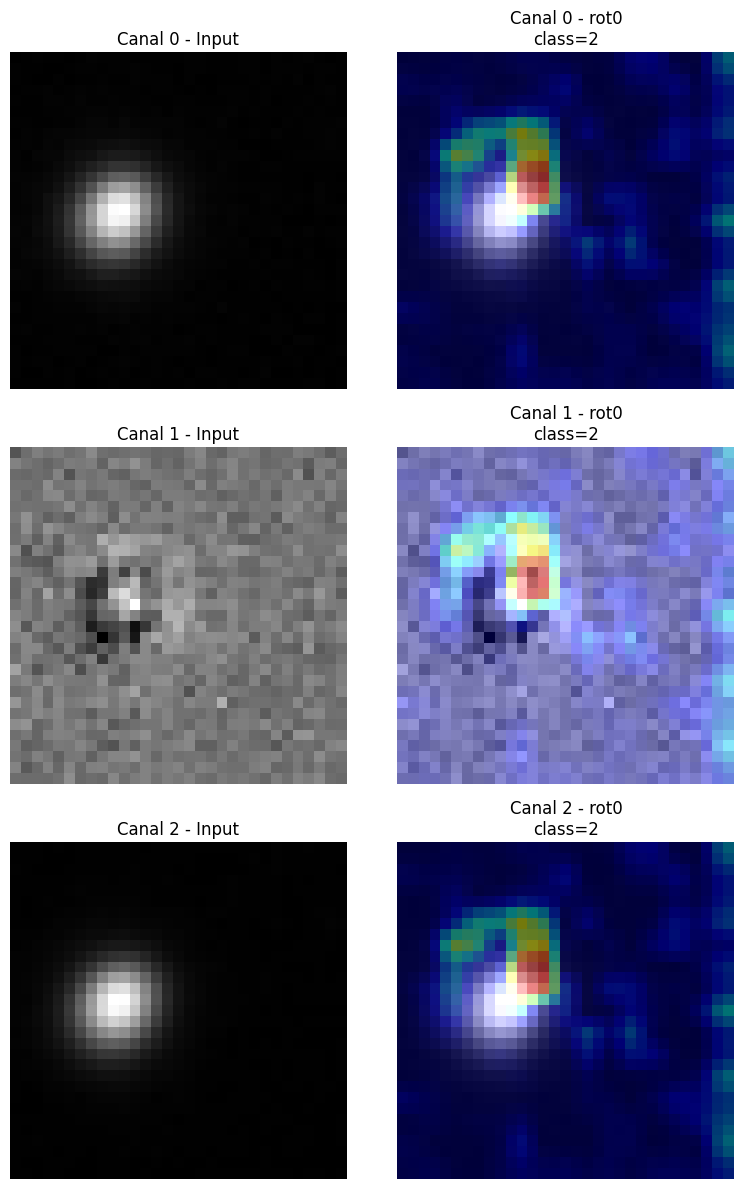

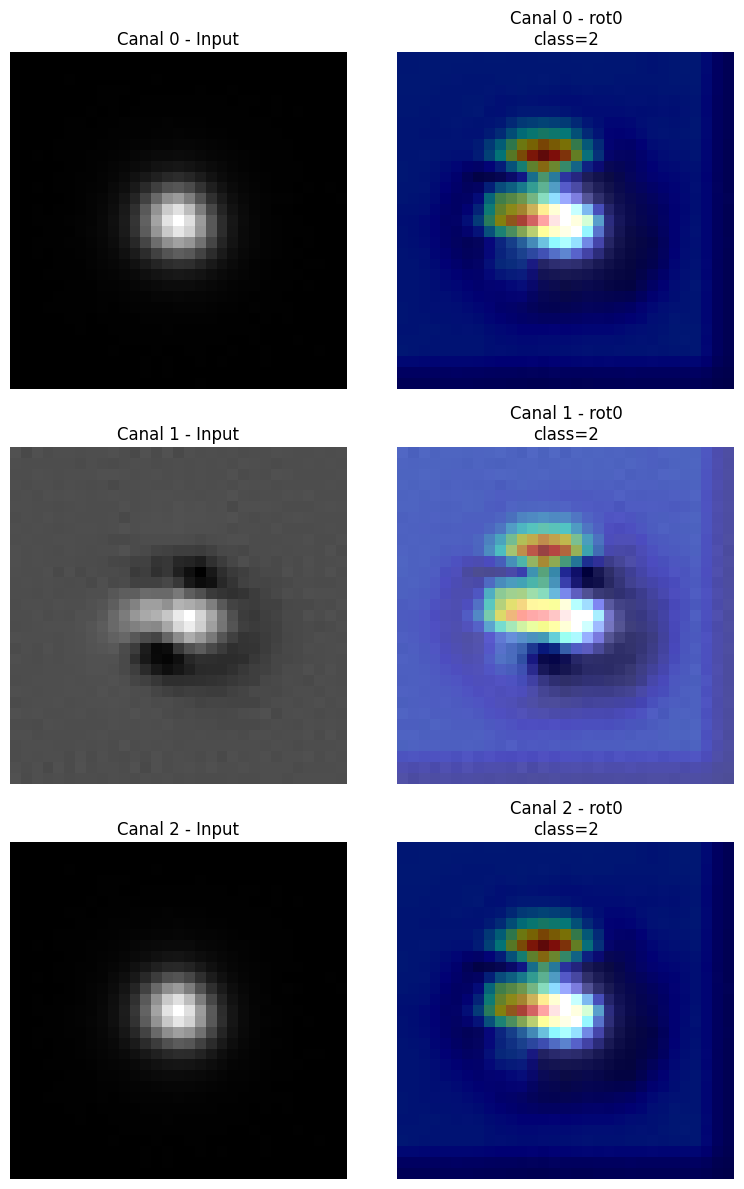

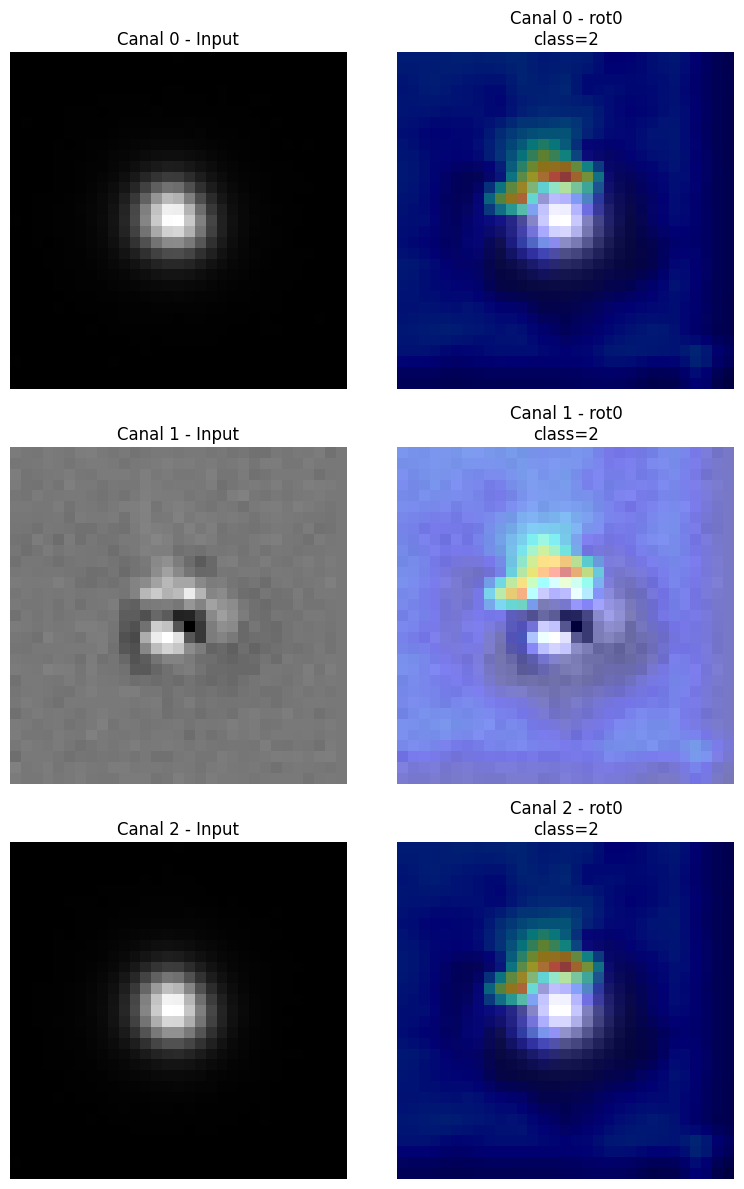

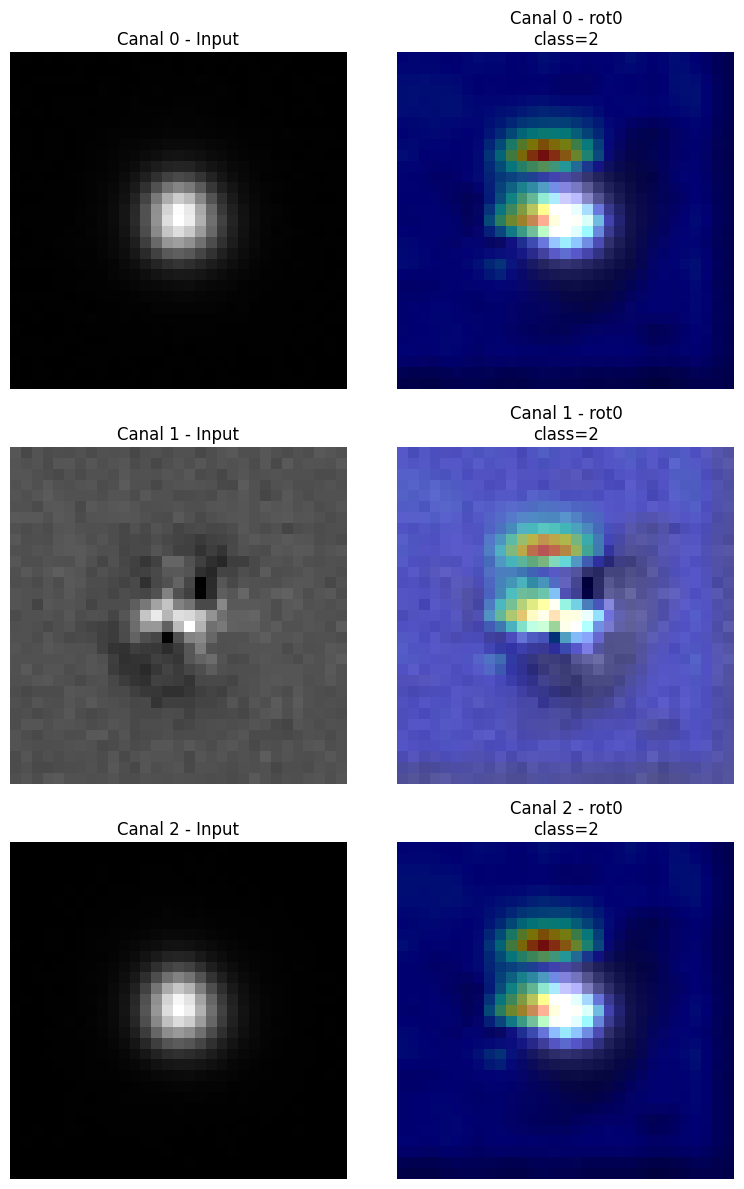

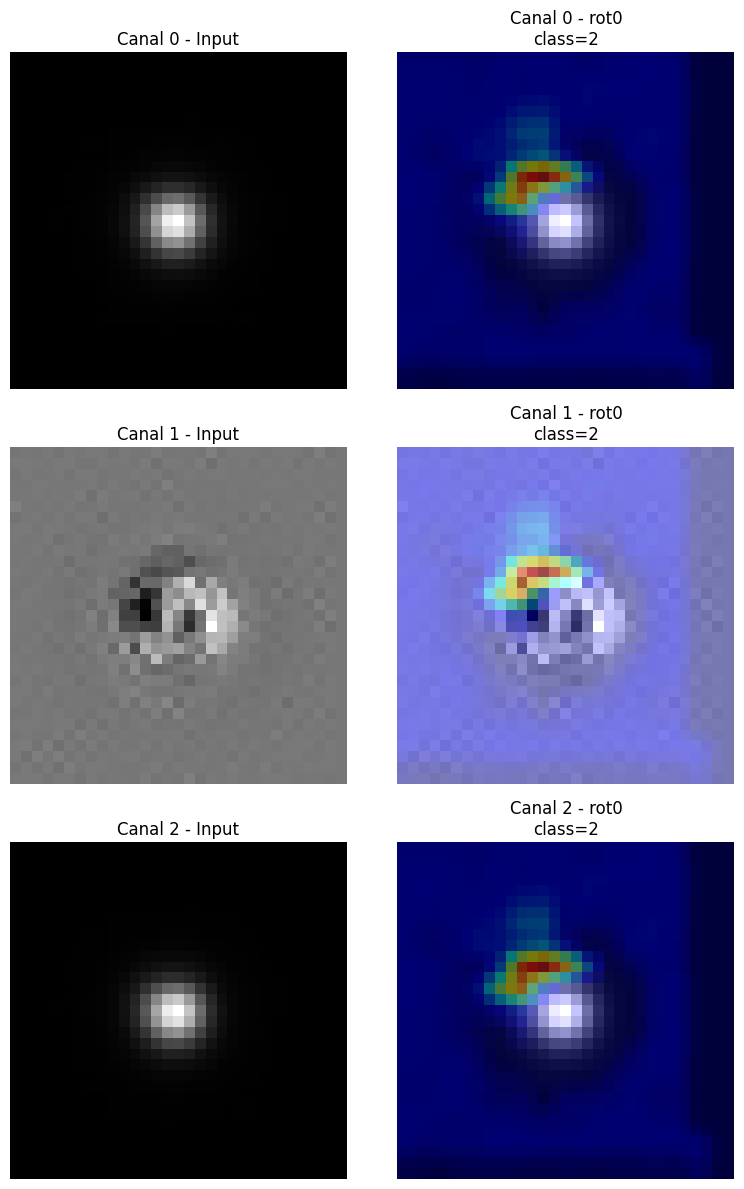

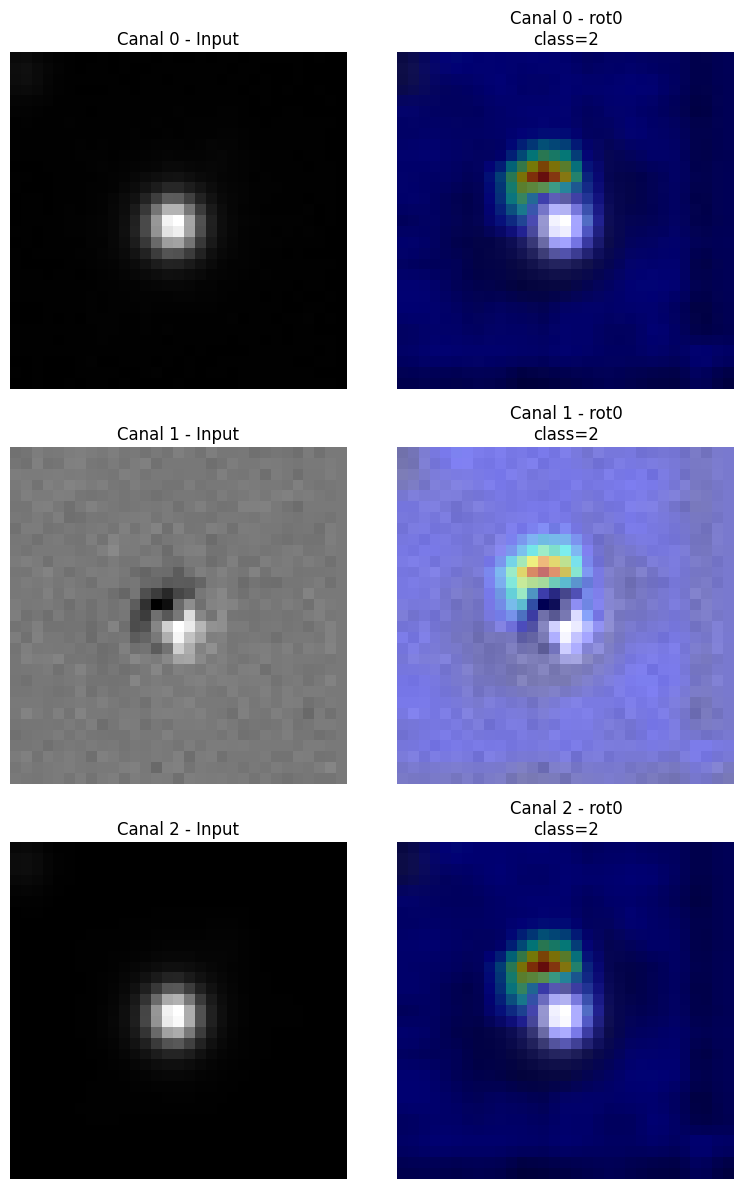

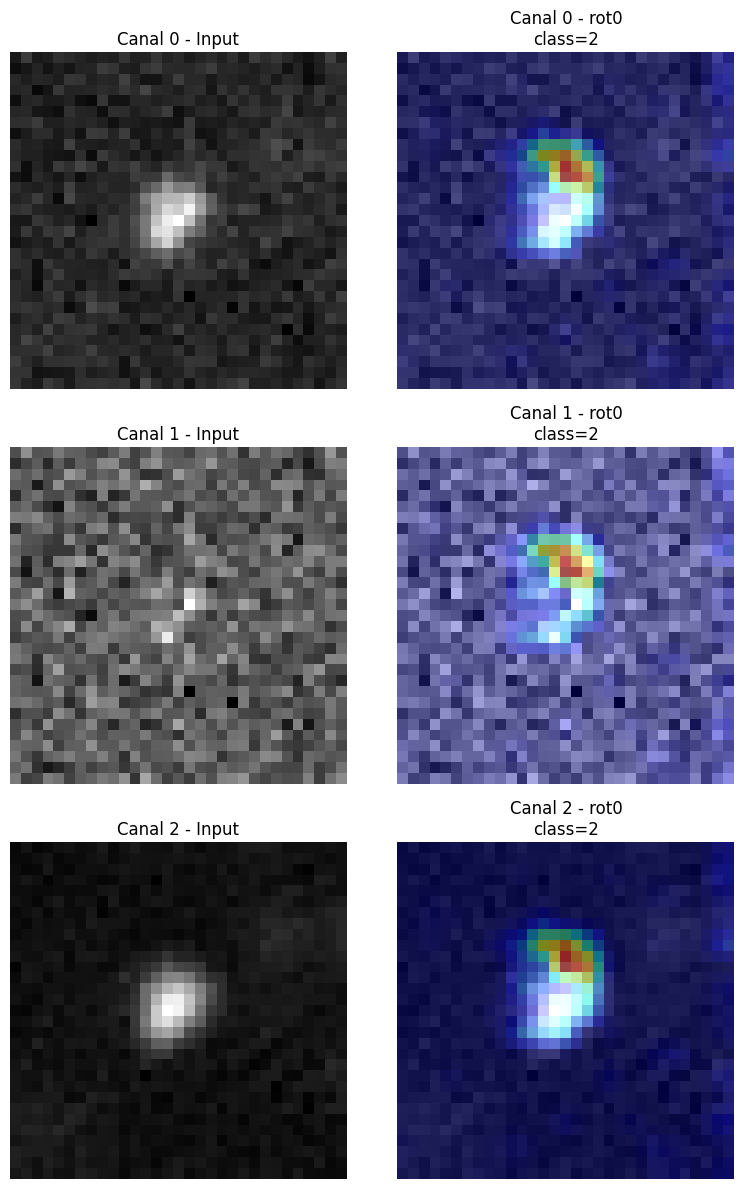

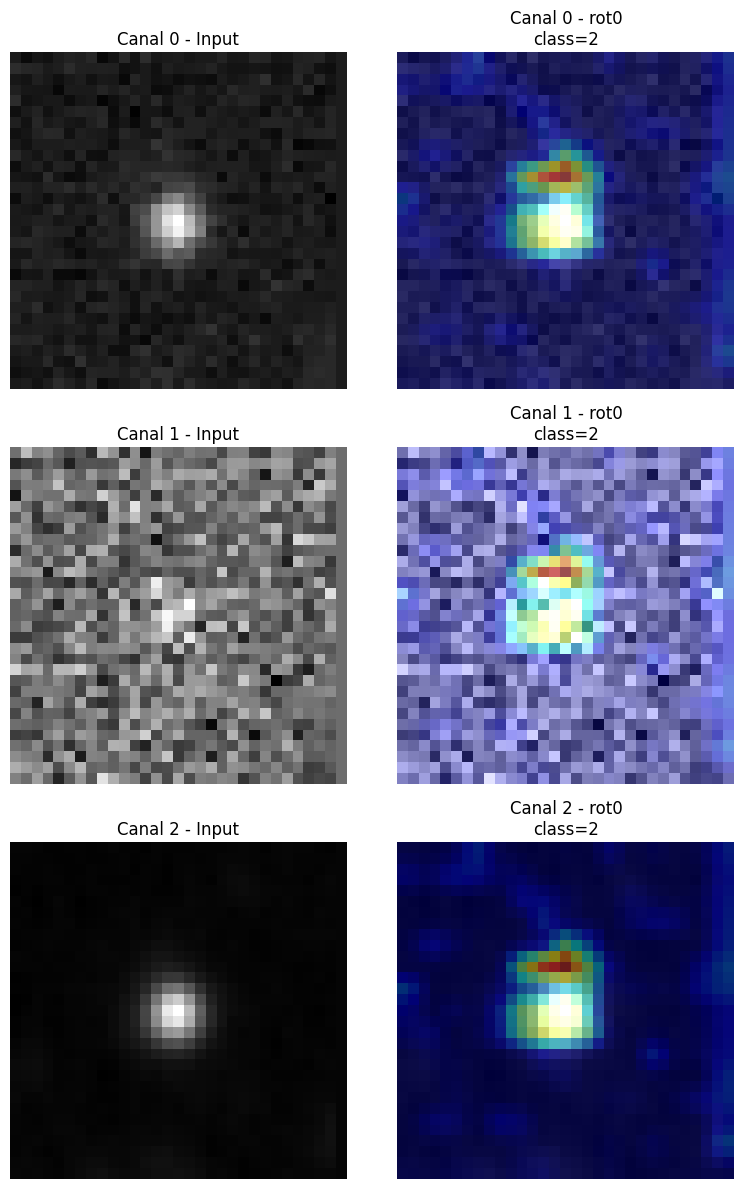

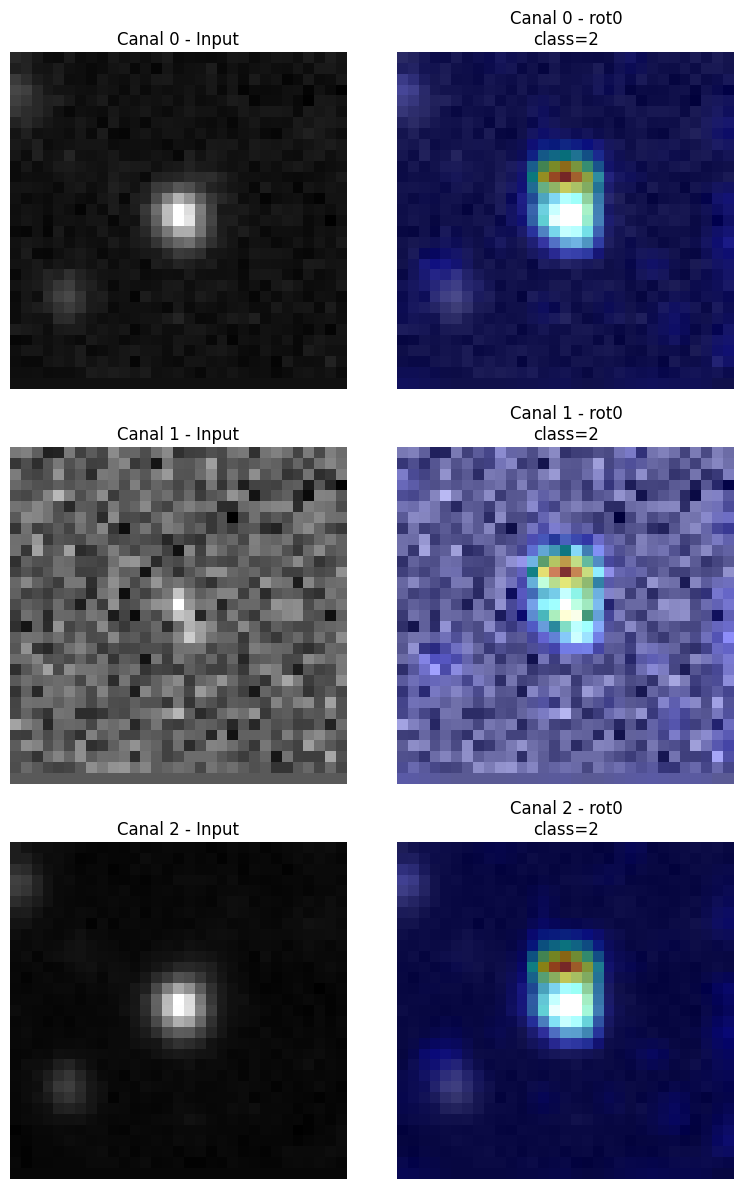

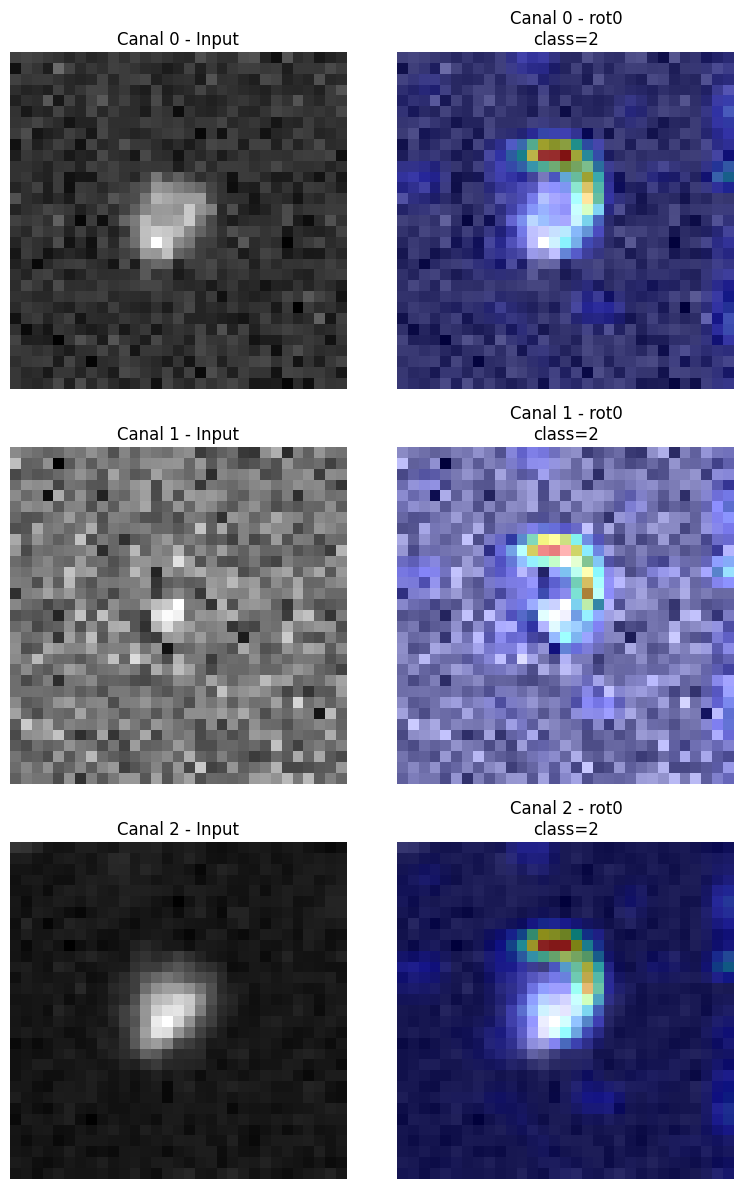

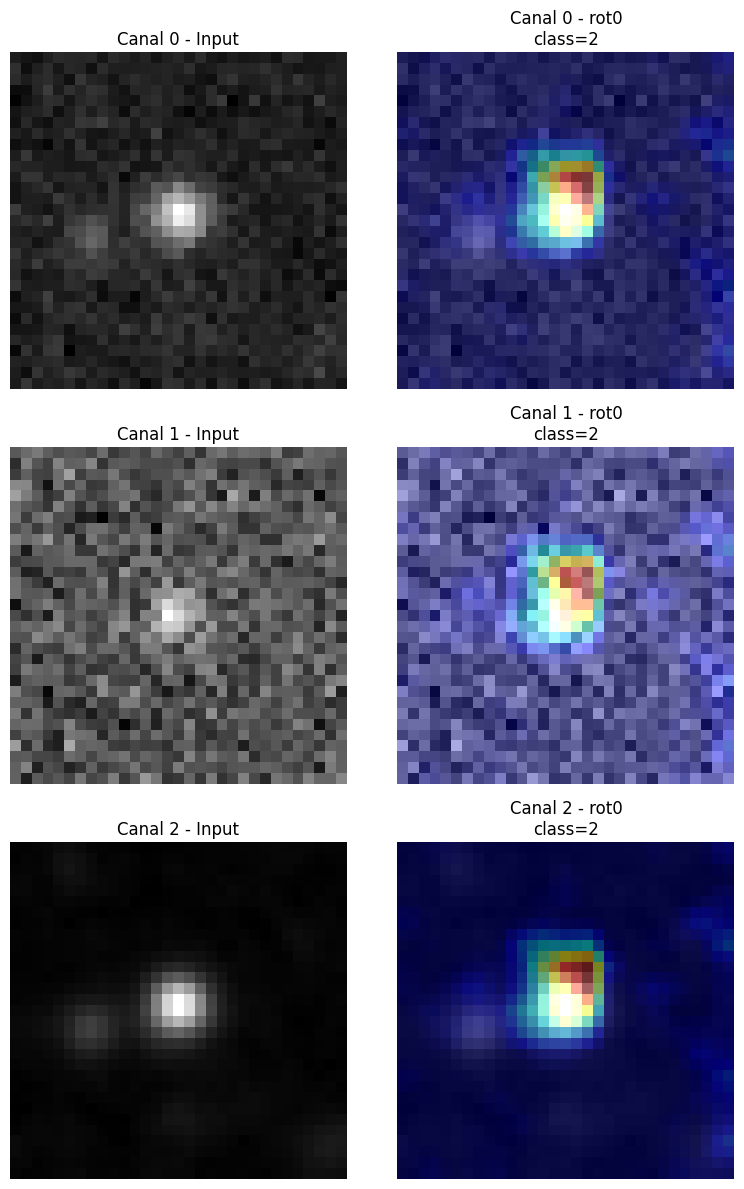

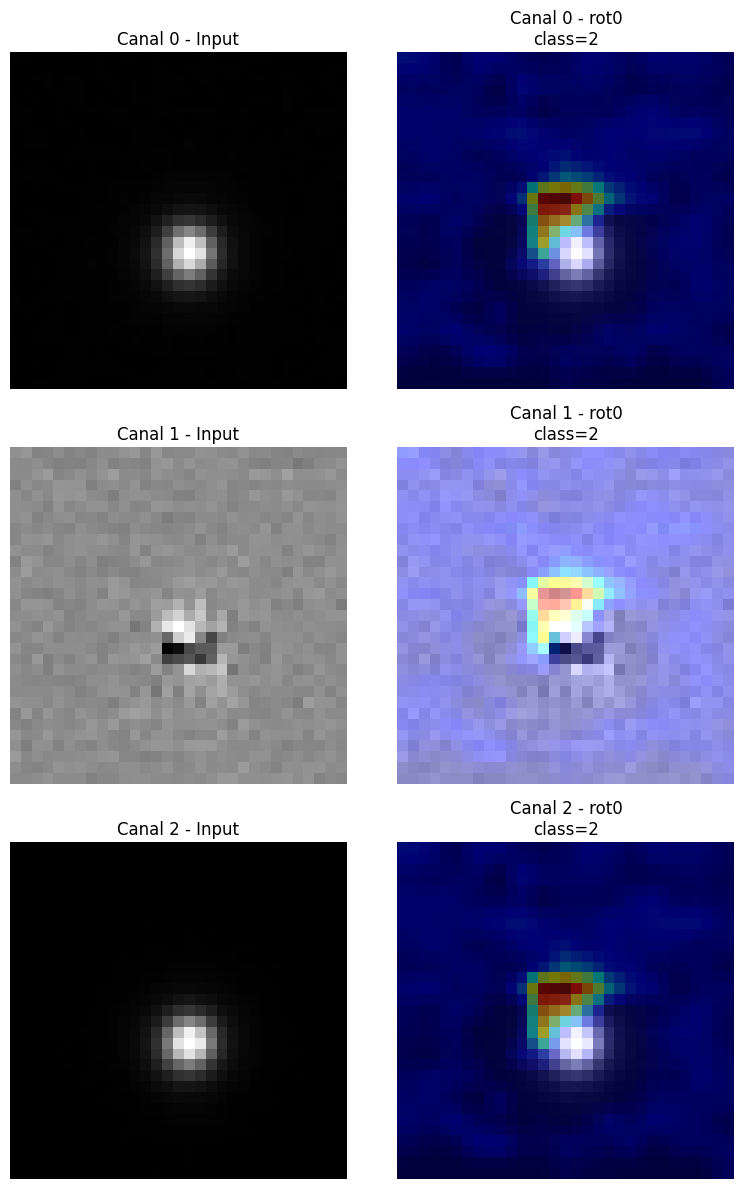

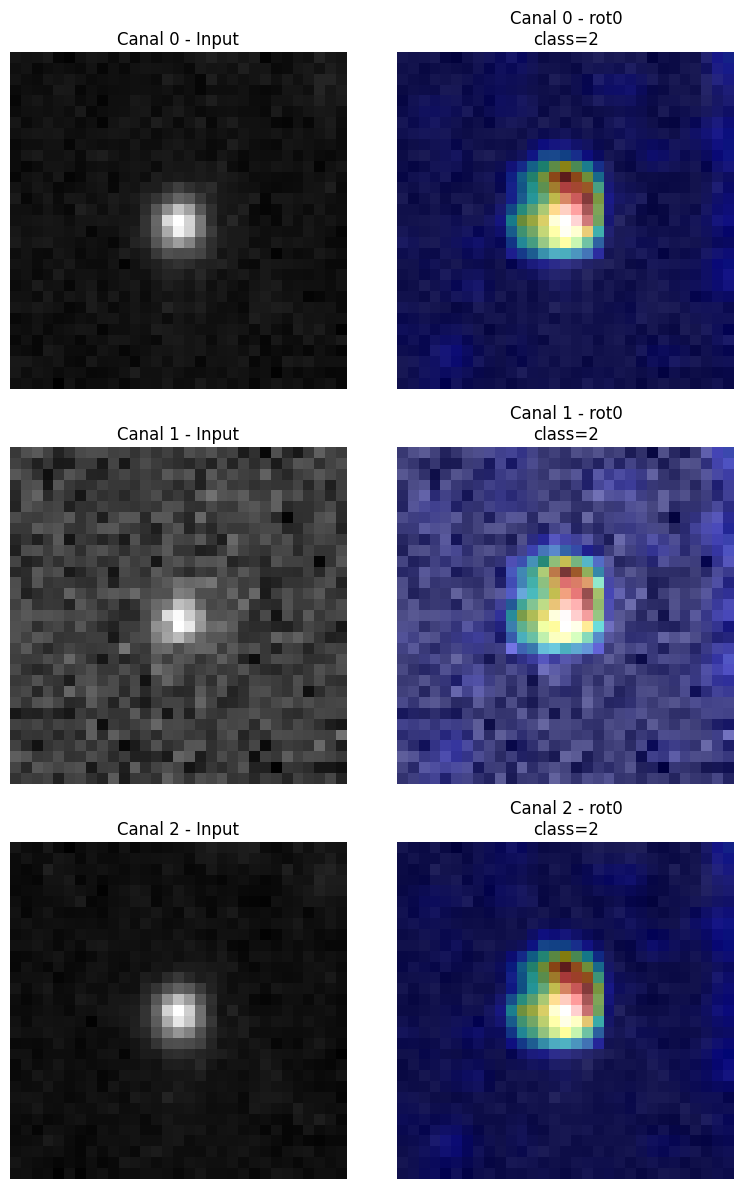

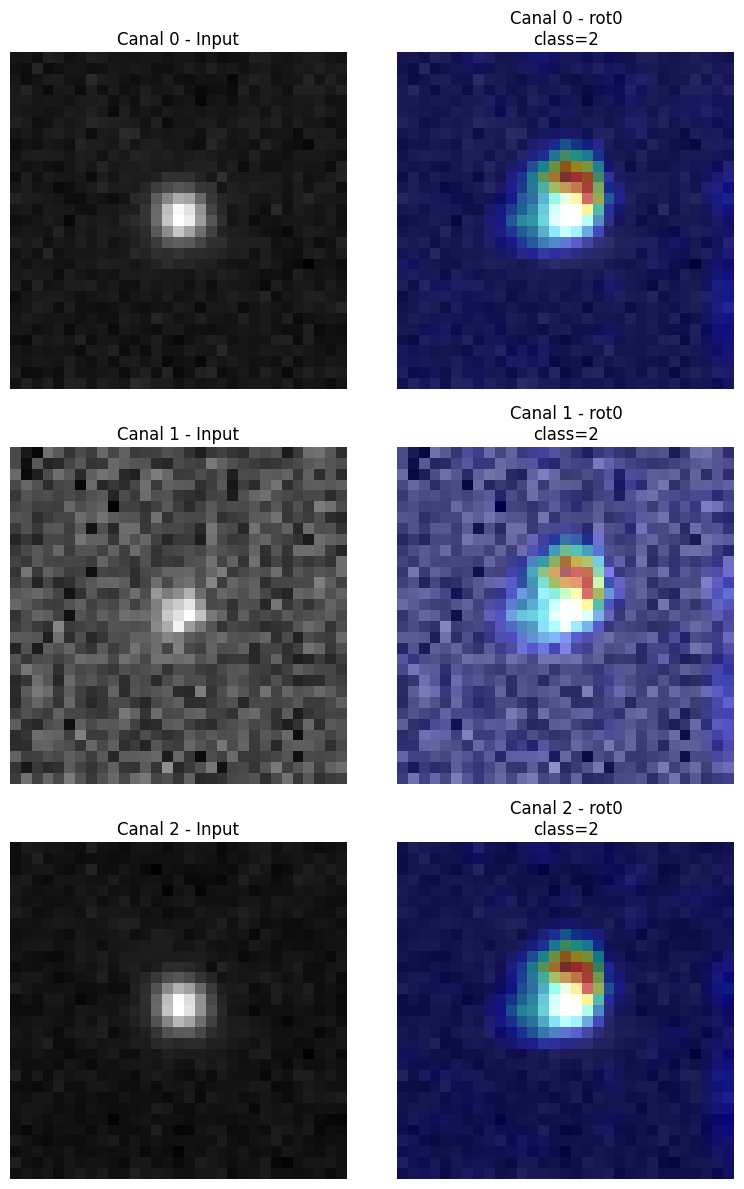

2025-08-20 15:20:02.305457: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


precision  recall  f1-score  support
AGN                0.29    0.63      0.40    52.00
SN                 0.33    0.11      0.17     9.00
VS                 0.83    0.88      0.85   454.00
asteroid           0.91    0.95      0.93   200.00
bogus              0.91    0.72      0.80   400.00
satellite          0.67    0.55      0.60    40.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.66    0.64      0.63  1155.00
weighted avg       0.84    0.81      0.81  1155.00

precision    recall  f1-score      support
AGN            0.605263  0.442308  0.511111    52.000000
SN             0.666667  0.222222  0.333333     9.000000
VS             0.879570  0.900881  0.890098   454.000000
asteroid       0.961353  0.995000  0.977887   200.000000
bogus          0.859259  0.870000  0.864596   400.000000
satellite      1.000000  0.925000  0.961039    40.000000
accuracy       0.881385  0.881385  0.881385     0.881385
macro avg      0.828685  0.725902  0.756344  1155.000000
weighted avg   0.876859  0.881385  0.877524  1155.000000

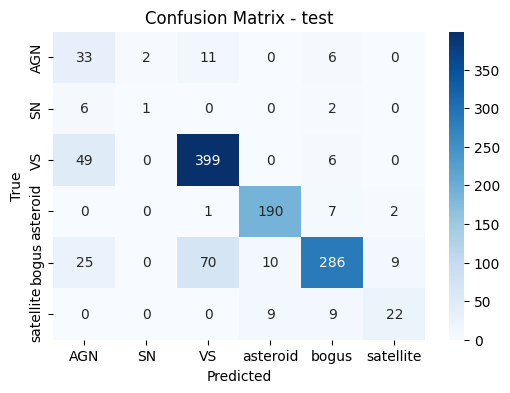

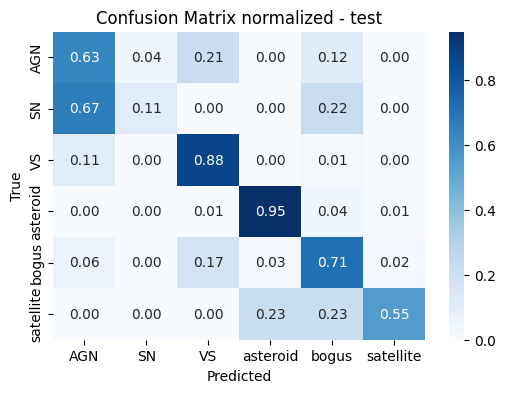

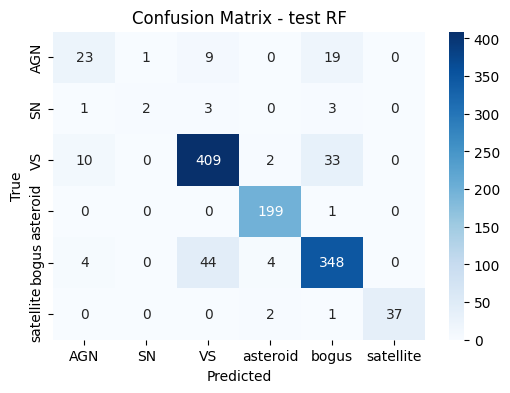

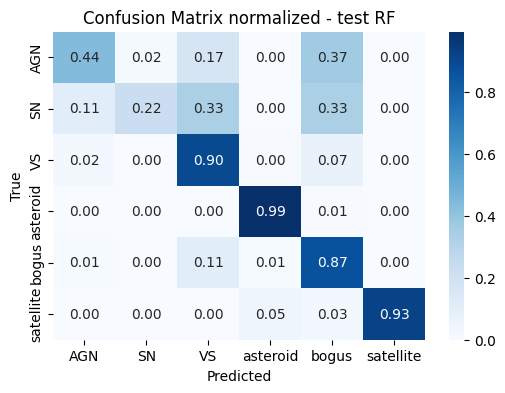

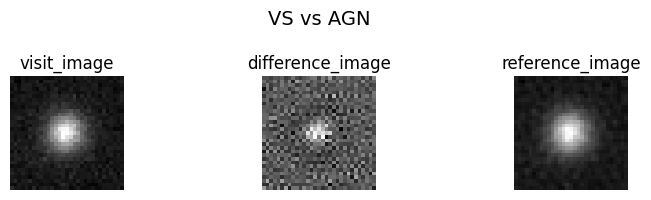

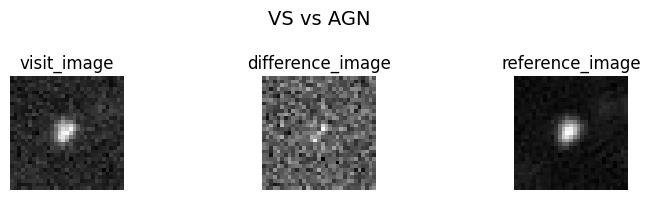

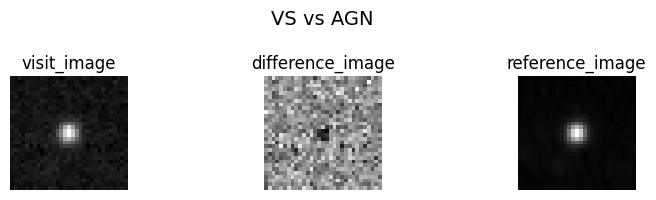

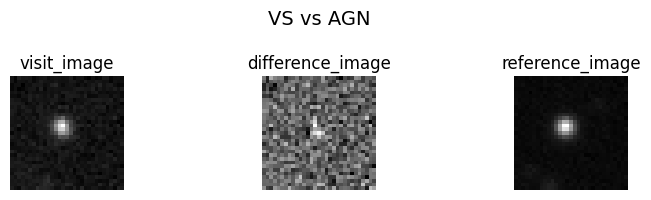

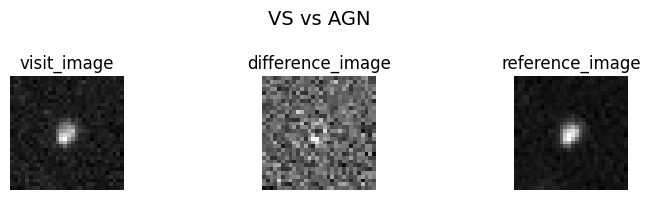

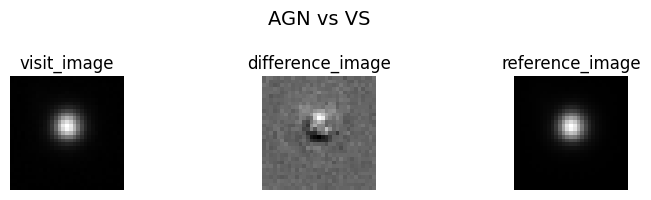

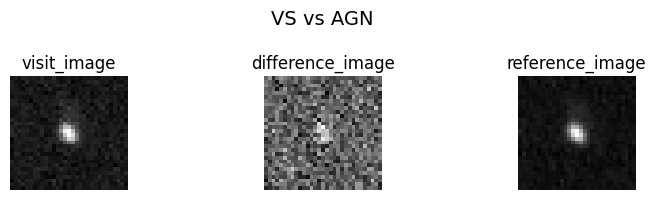

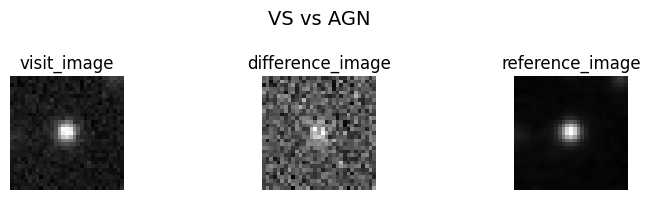

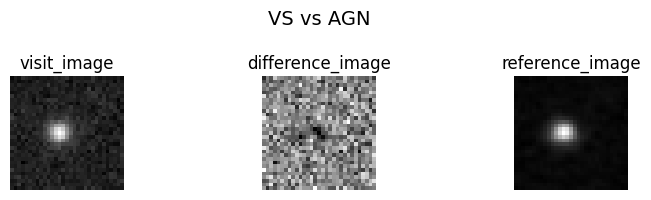

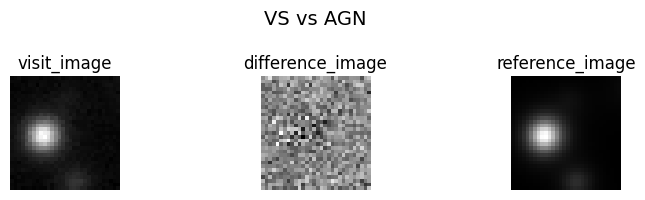

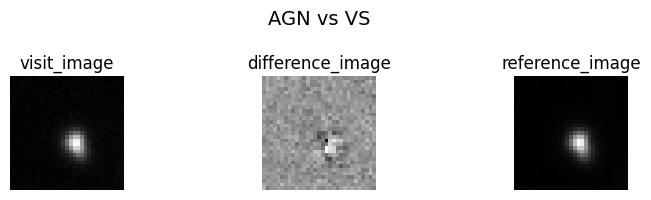

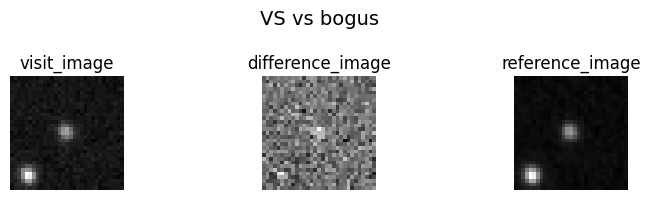

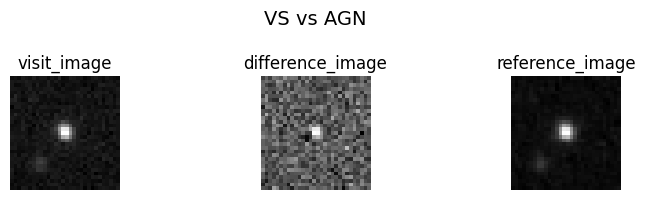

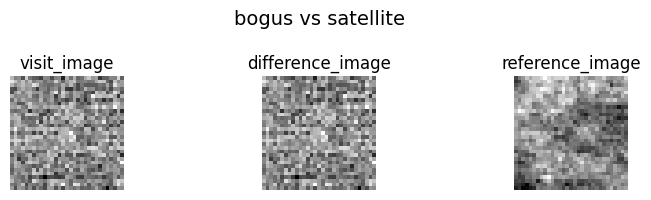

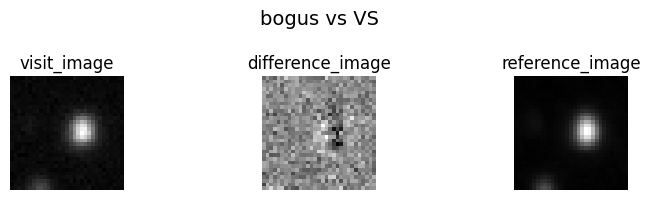

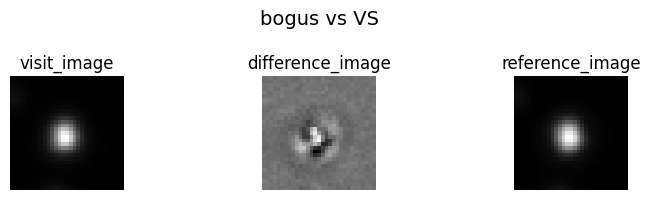

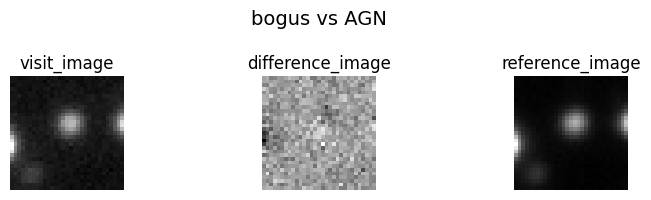

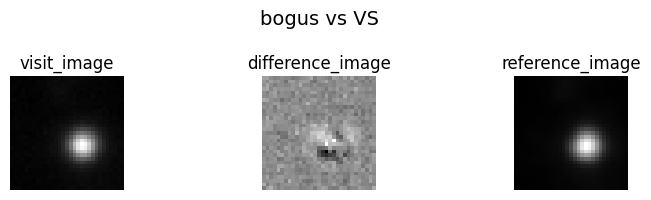

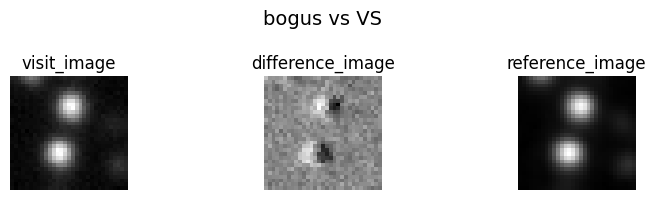

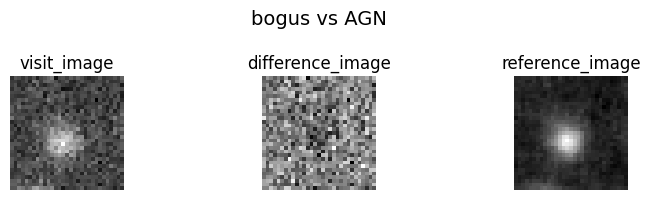

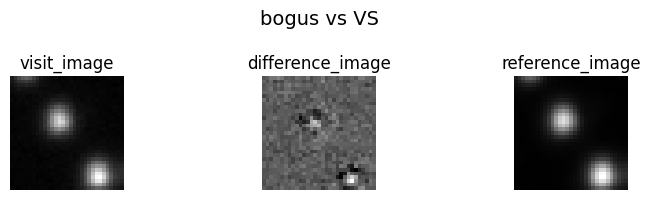

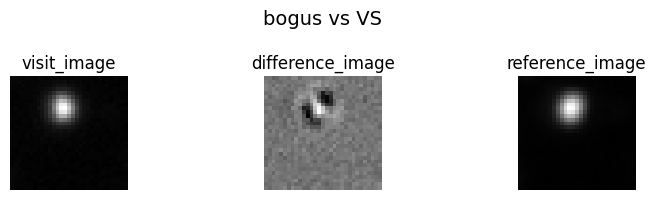

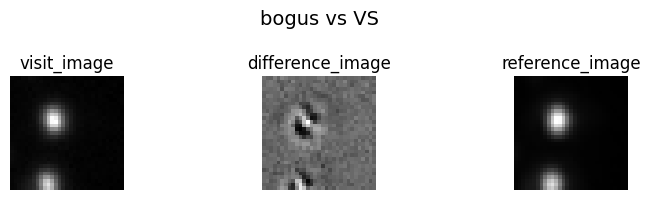

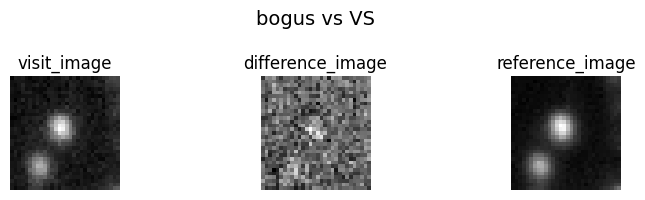

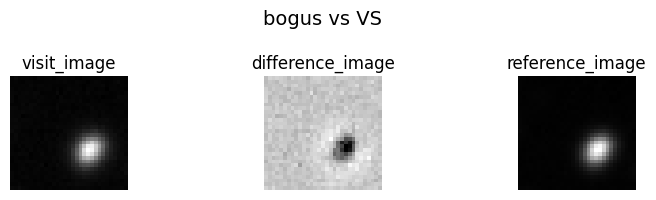

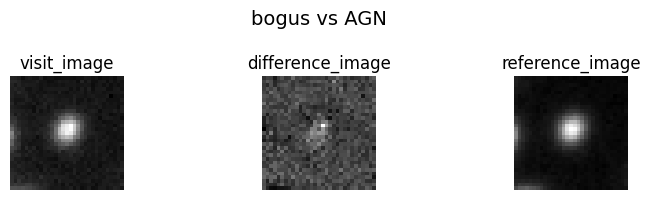

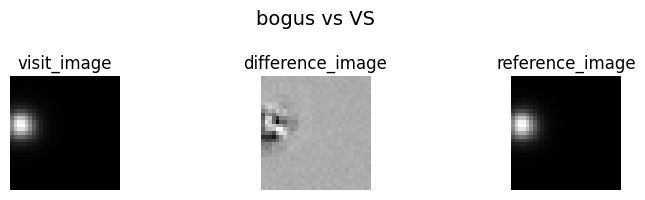

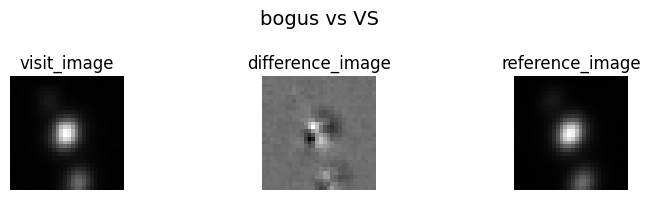

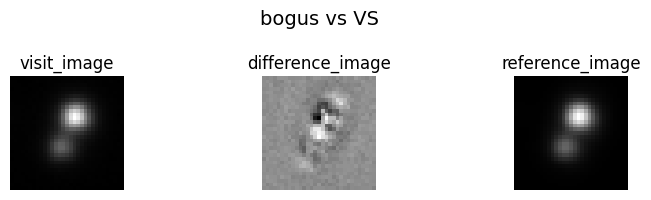

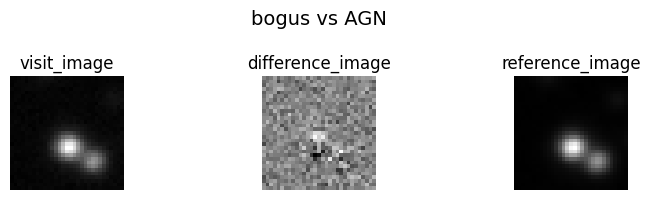

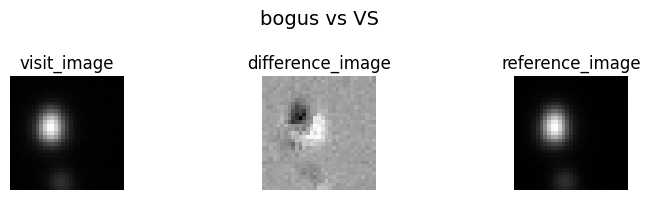

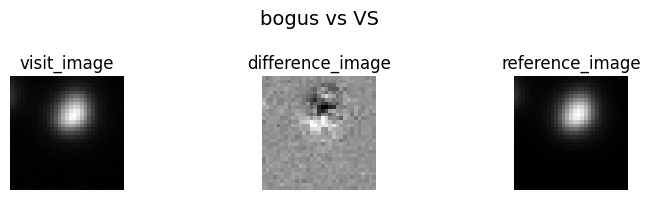

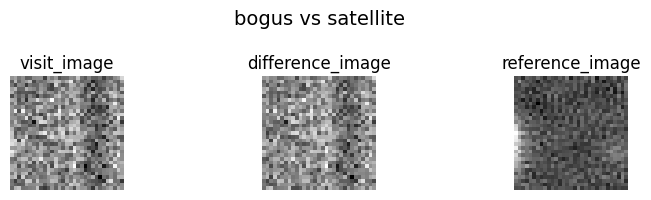

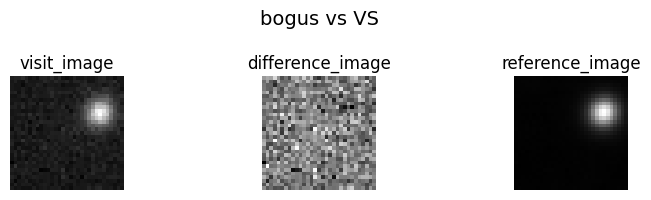

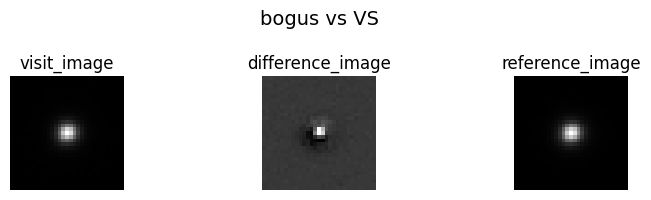

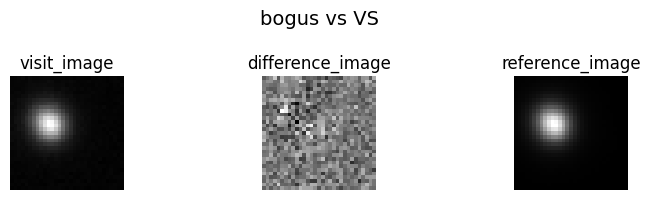

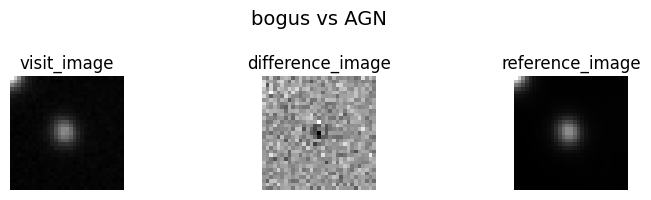

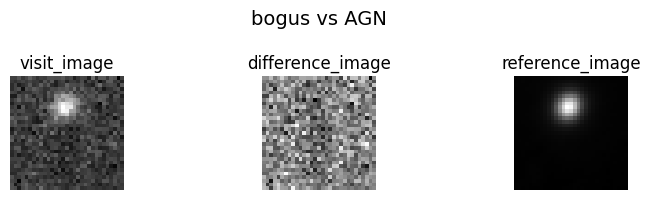

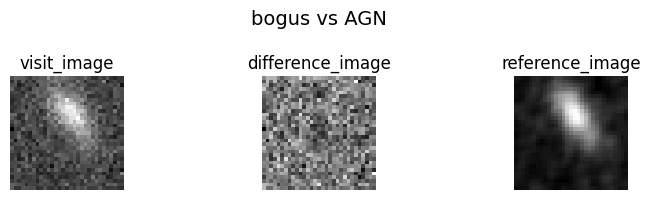

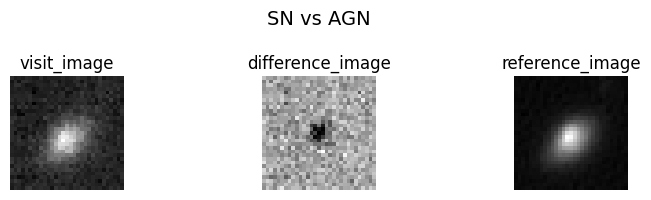

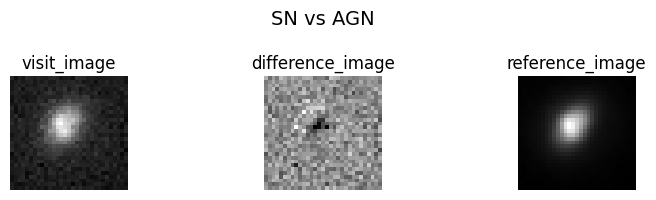

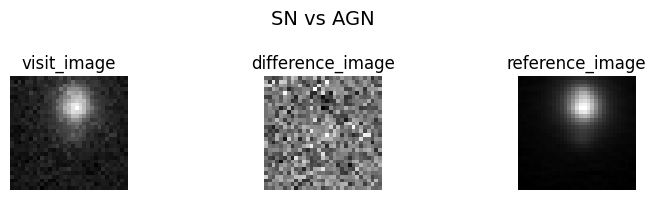

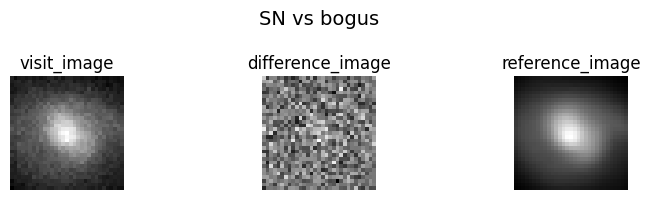

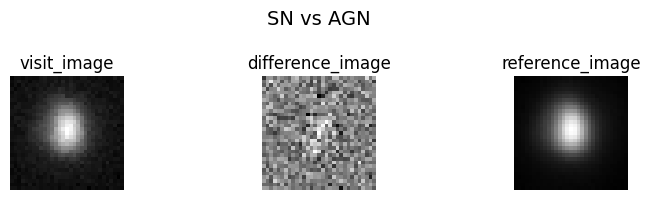

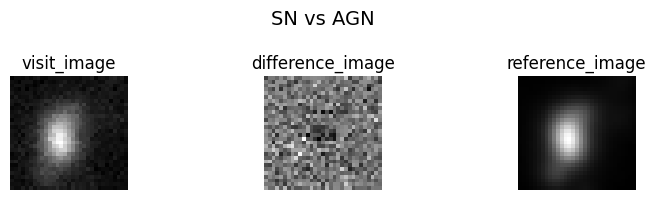

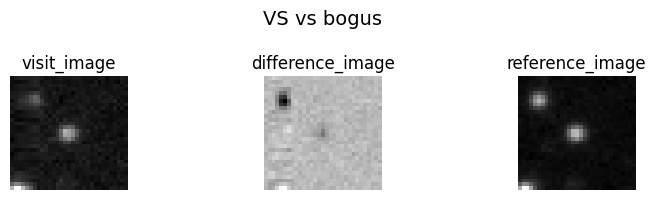

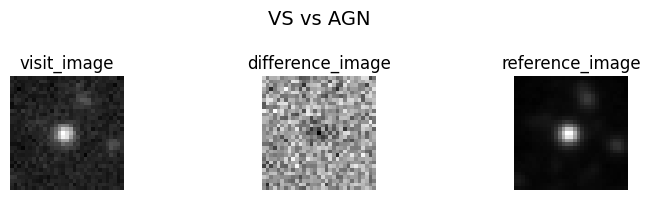

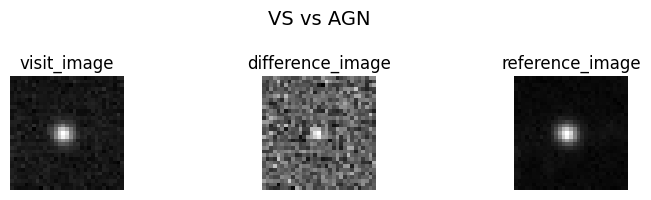

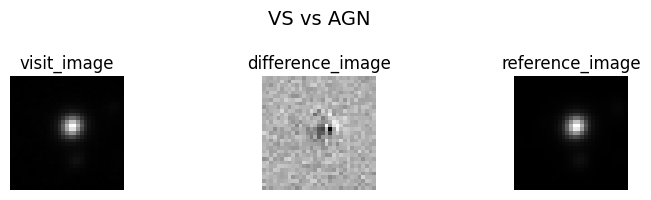

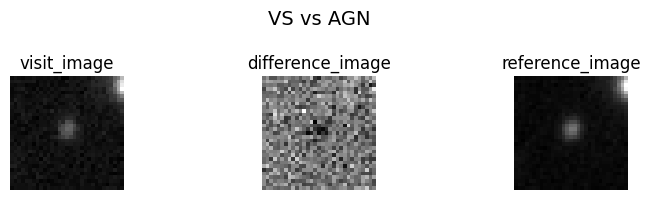

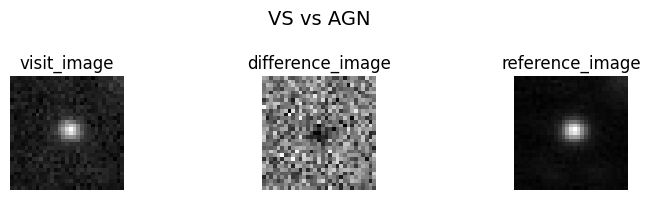

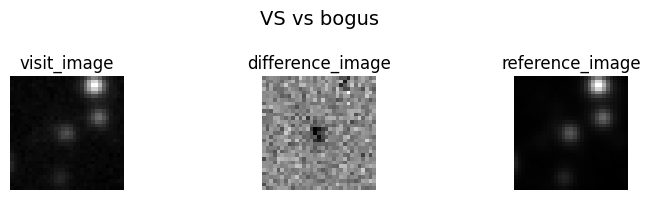

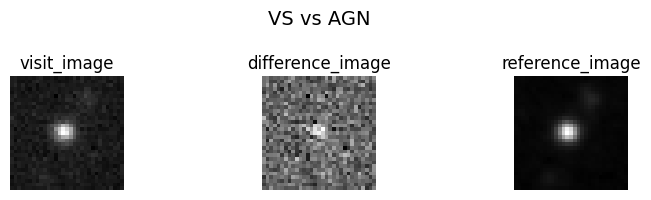

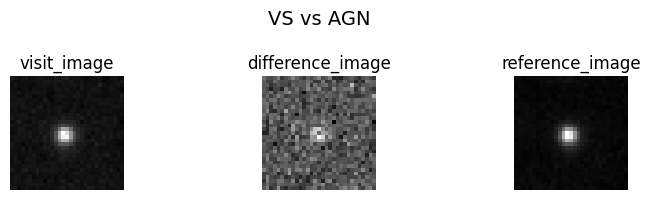

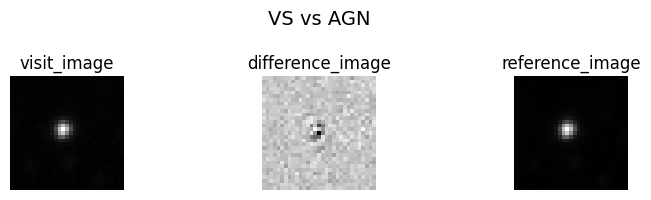

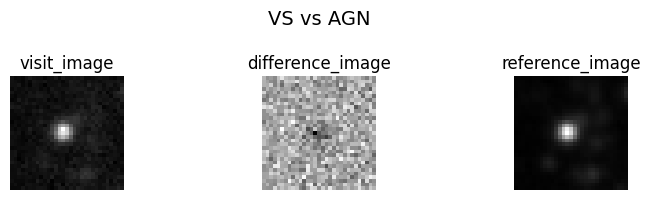

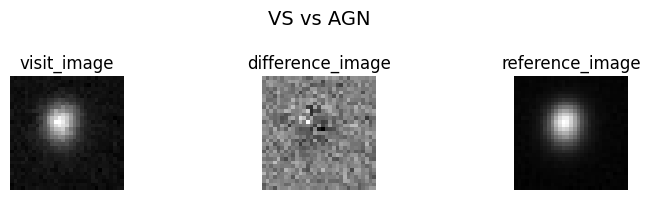

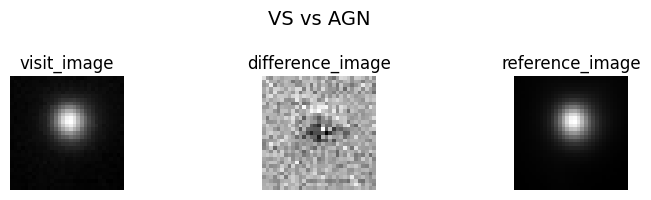

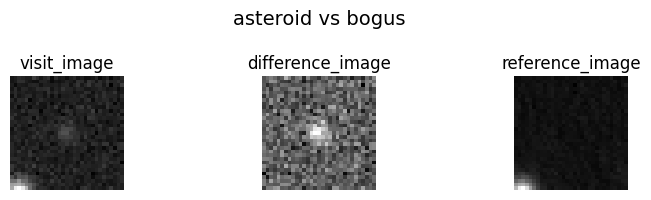

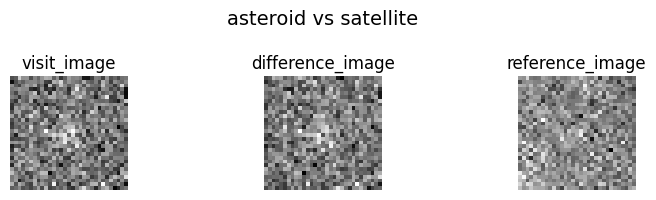

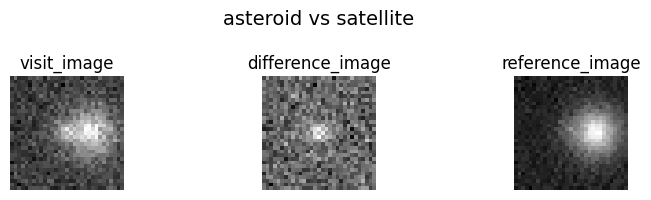

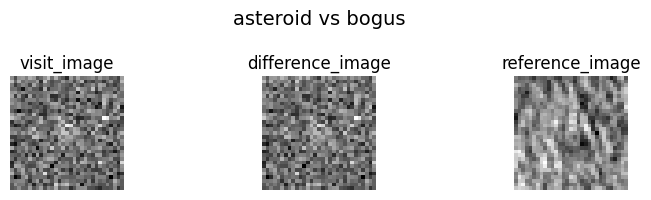

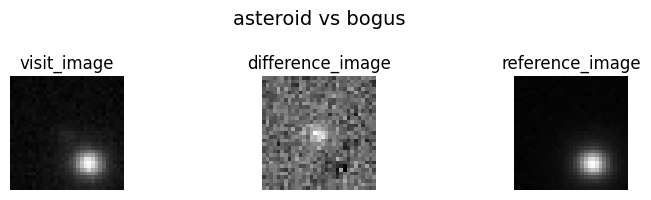

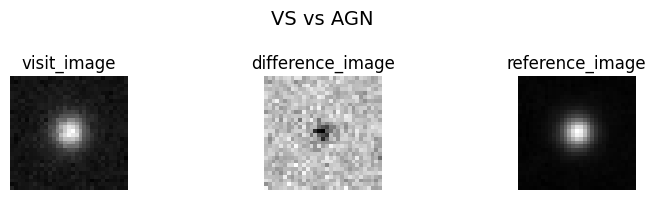

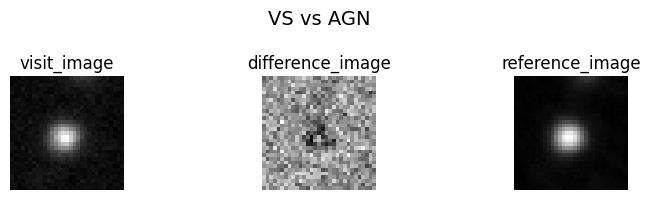

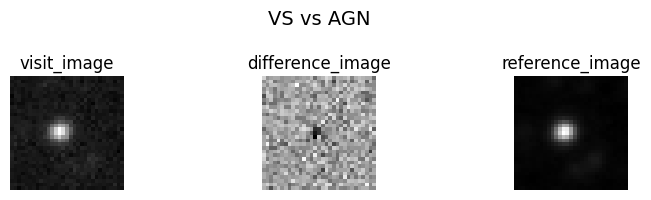

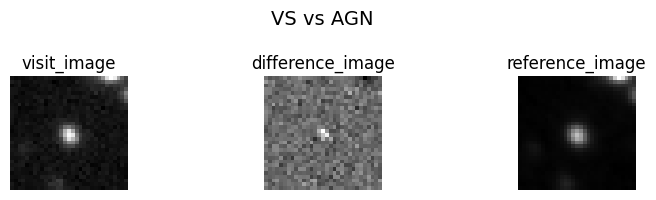

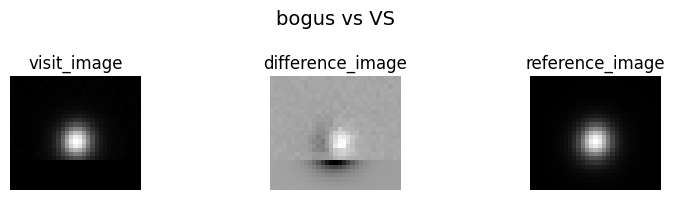

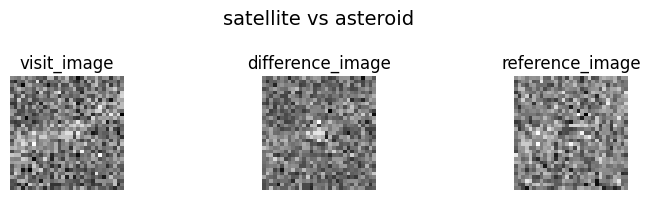

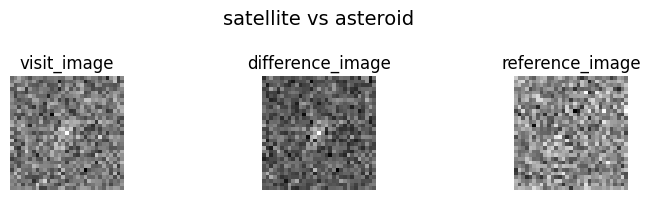

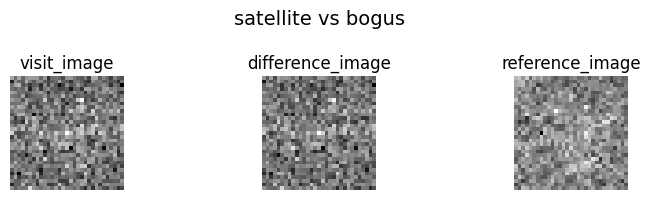

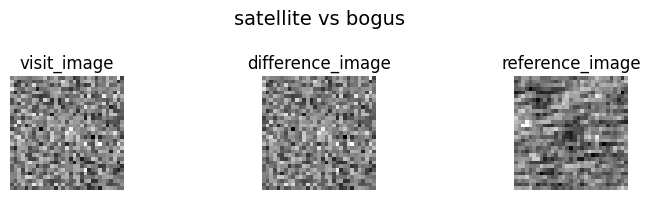

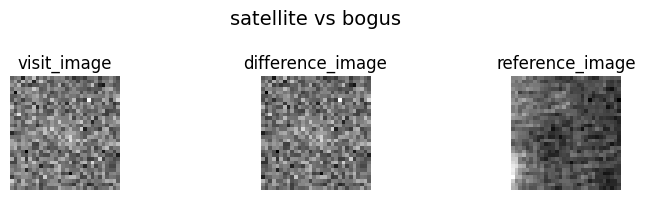

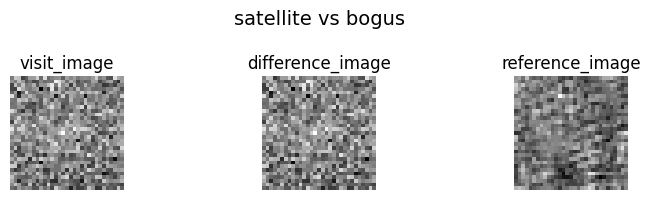

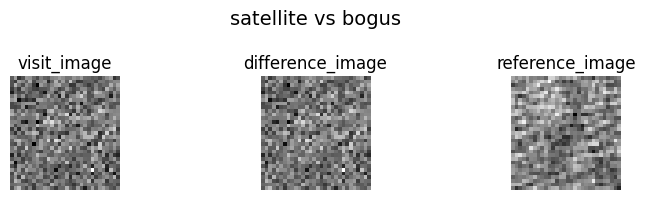

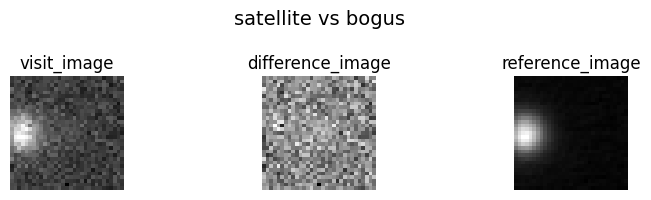

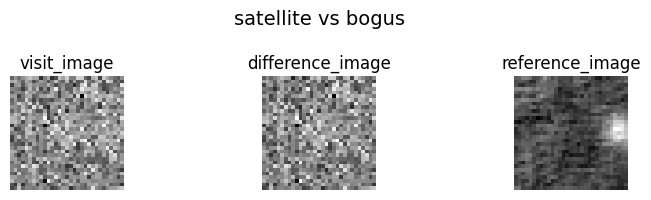

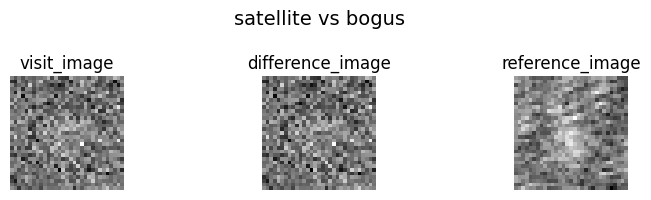

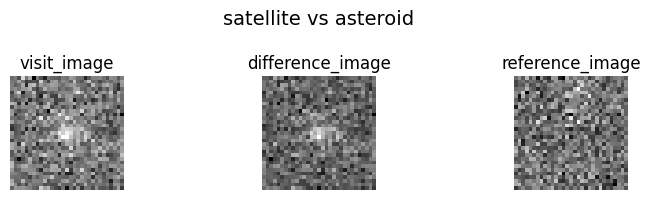

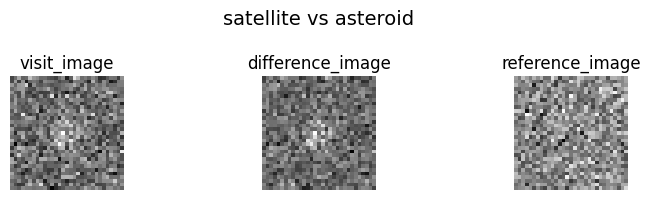

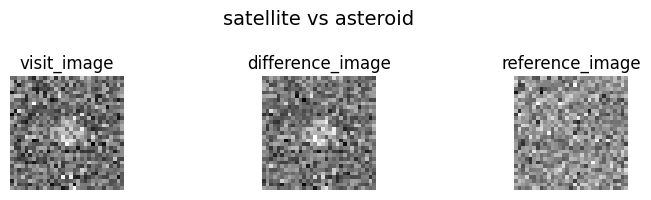

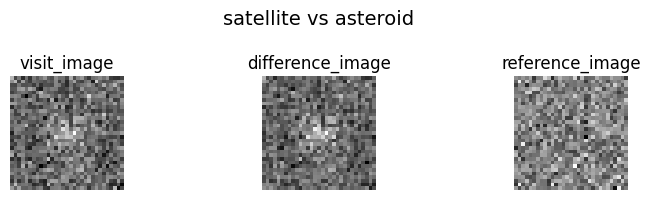

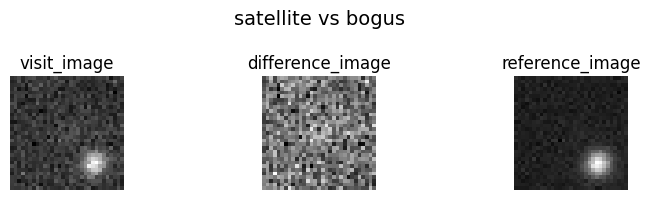

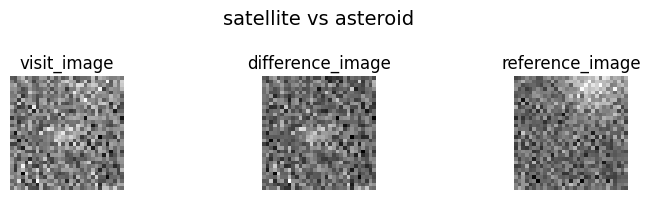

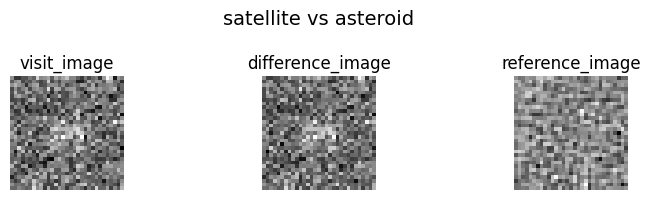

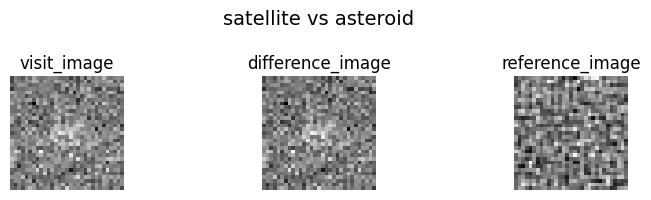

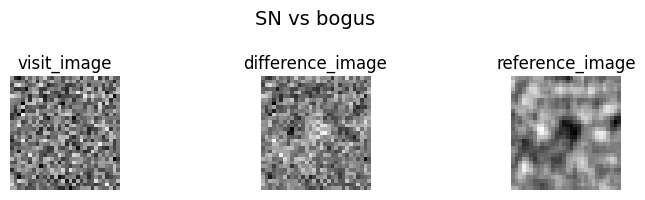

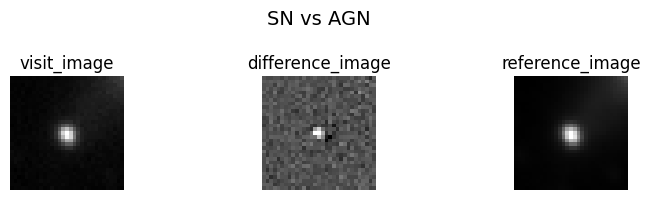

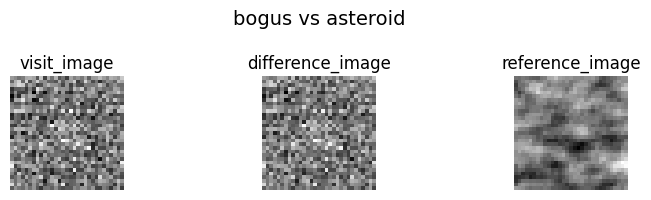

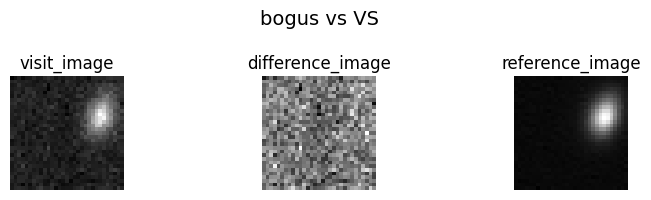

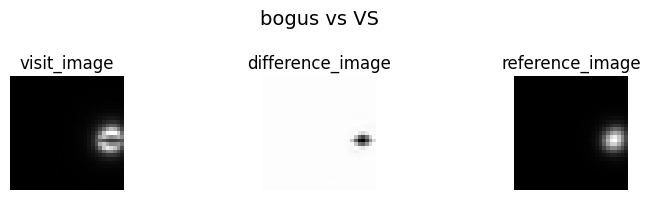

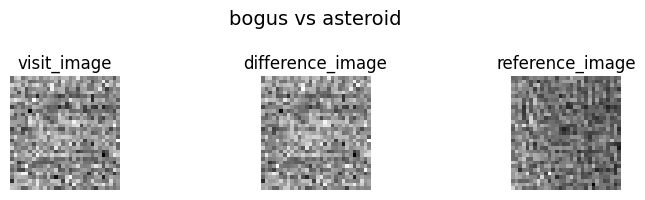

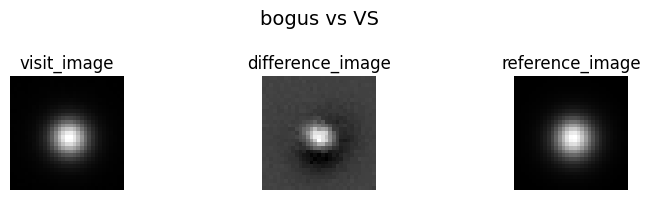

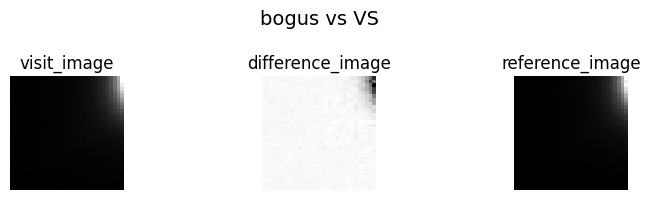

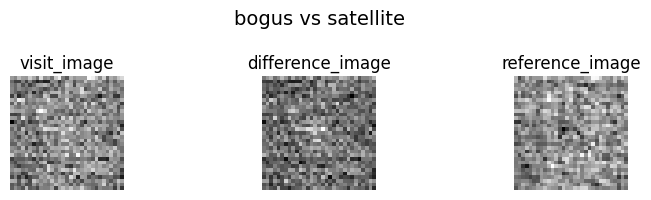

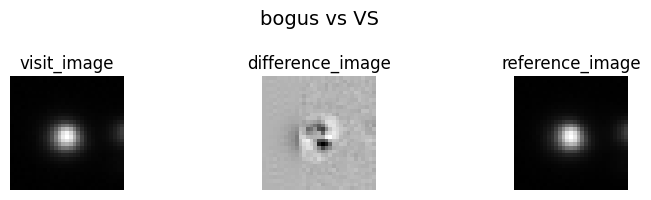

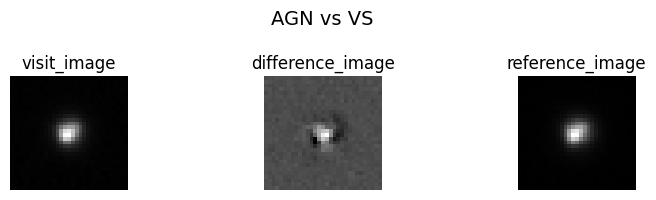

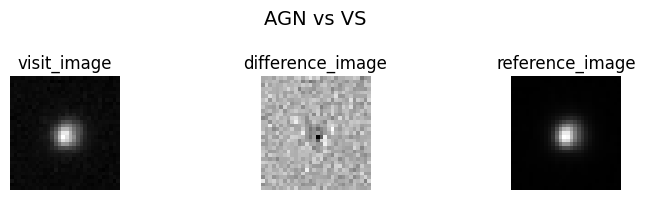

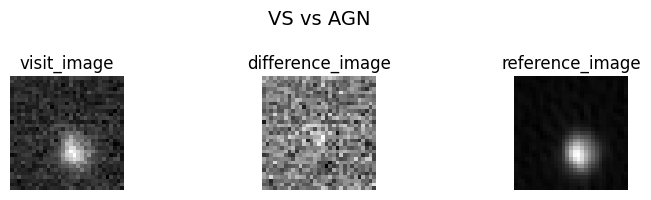

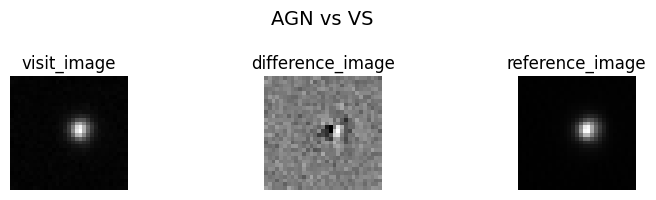

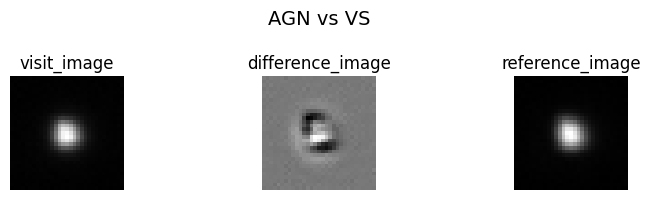

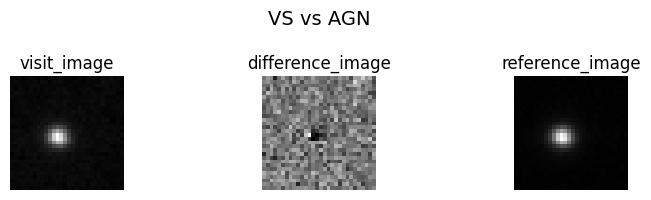

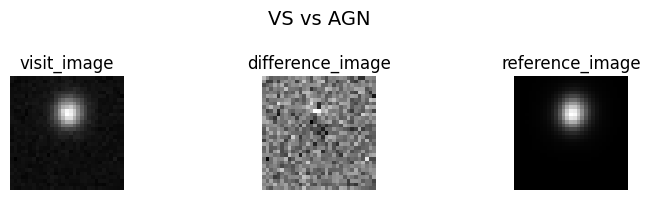

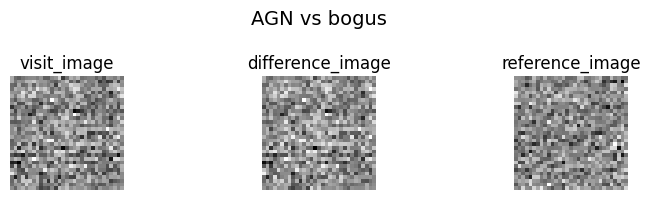

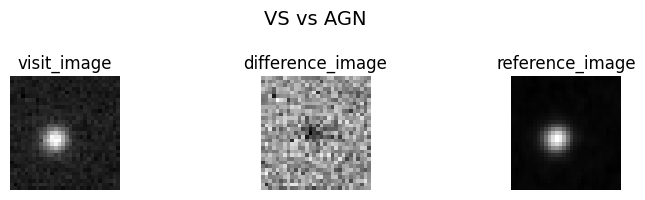

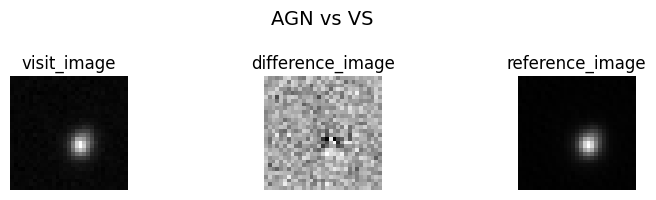

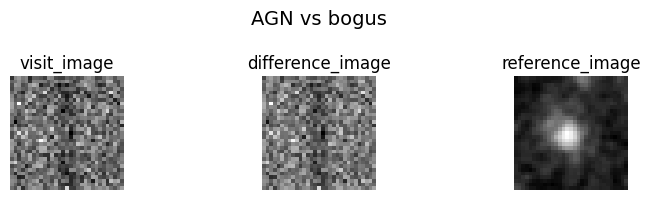

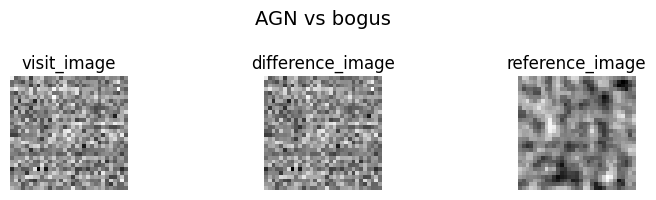

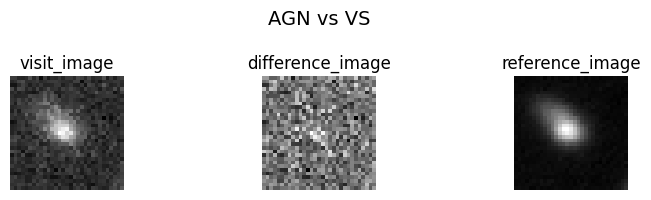

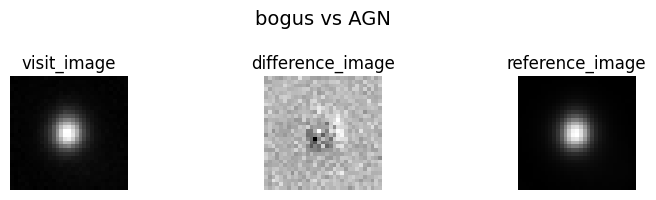

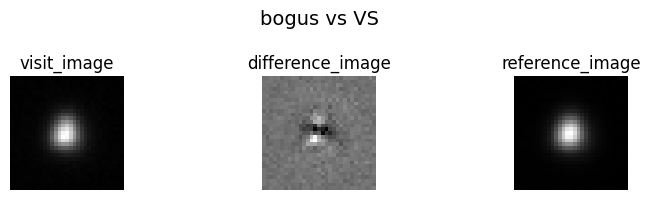

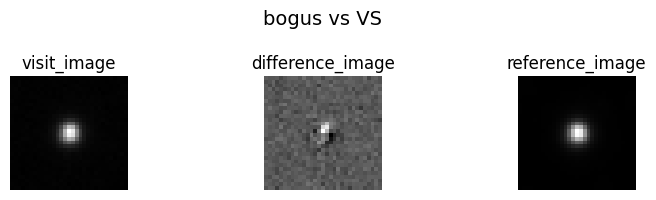

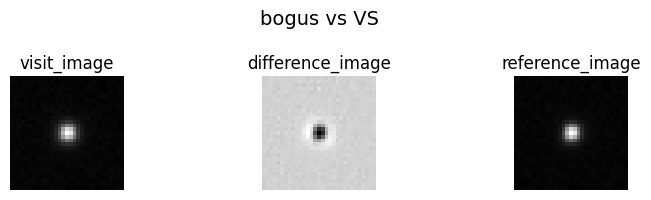

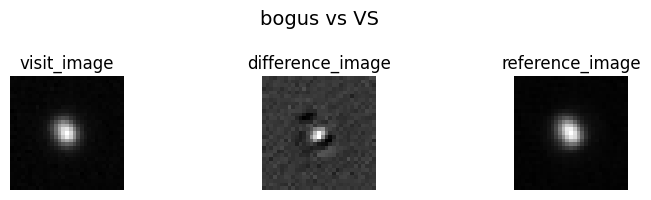

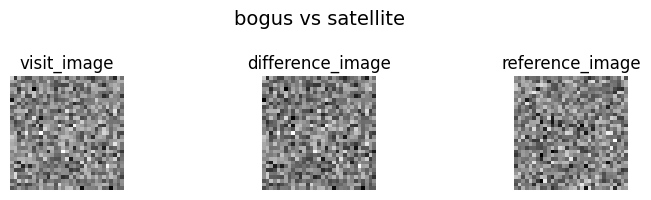

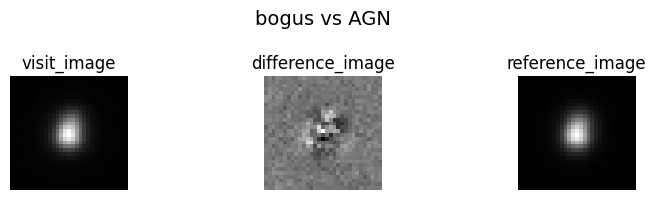

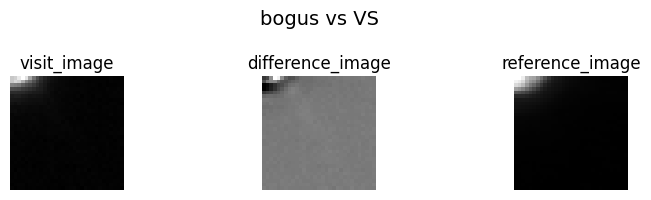

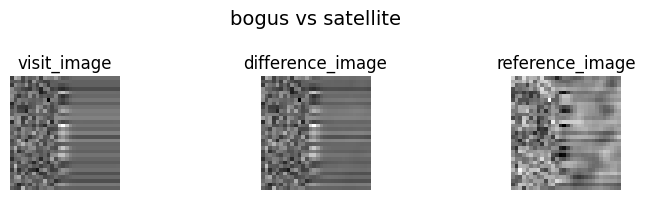

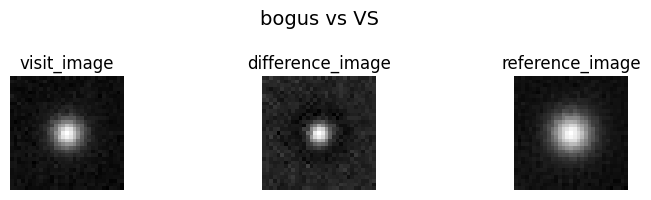

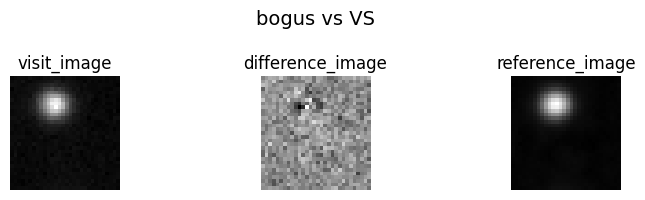

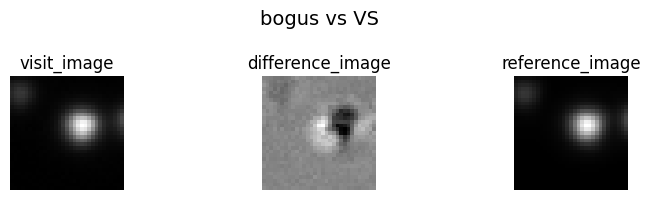

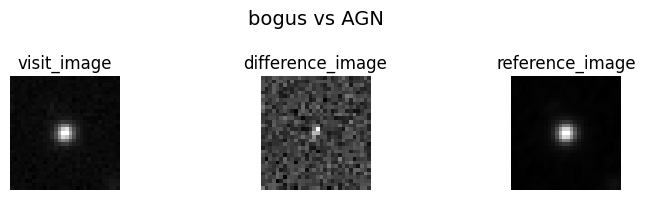

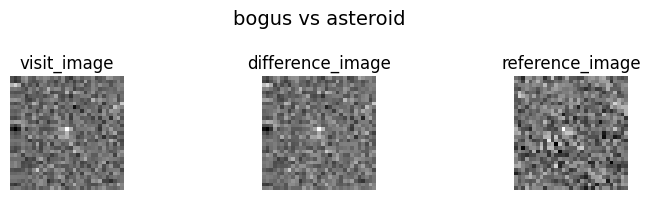

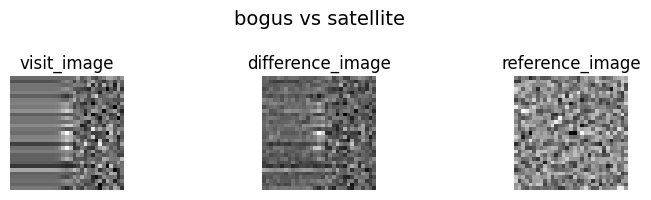

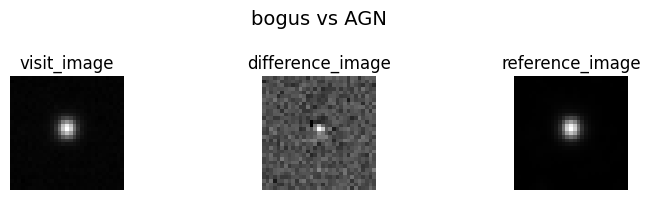

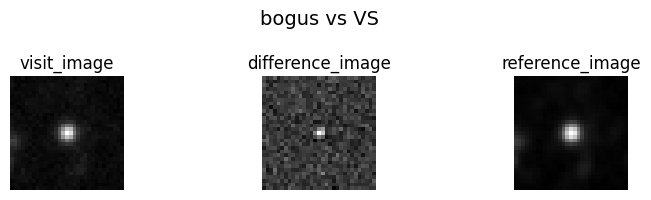

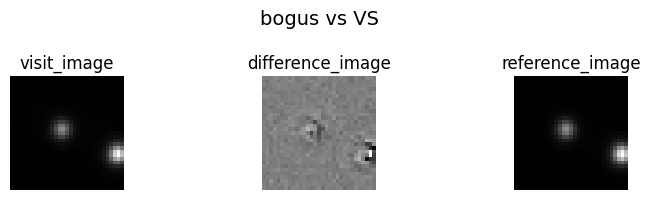

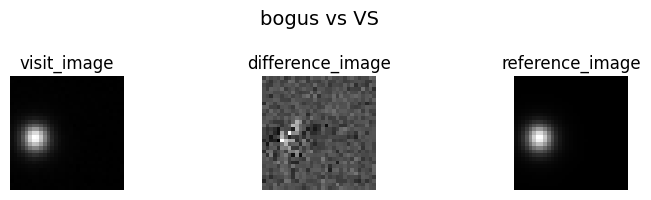

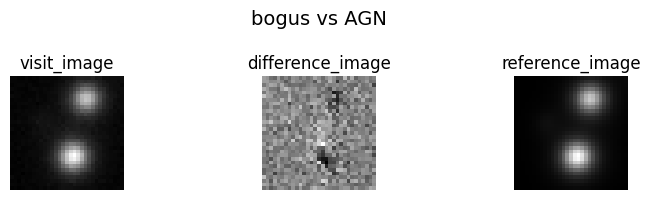

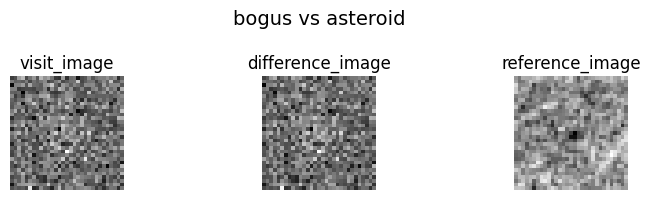

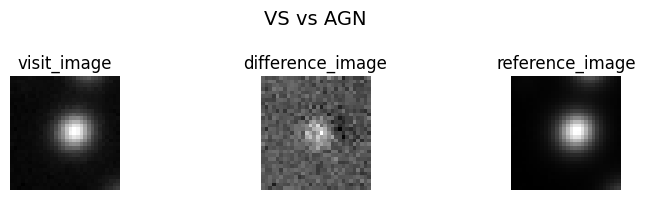

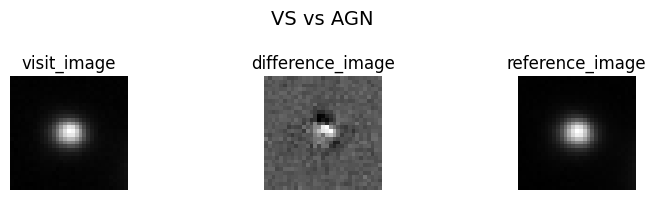

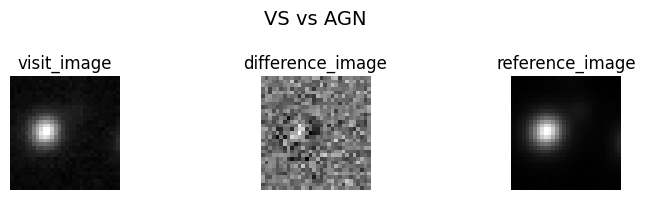

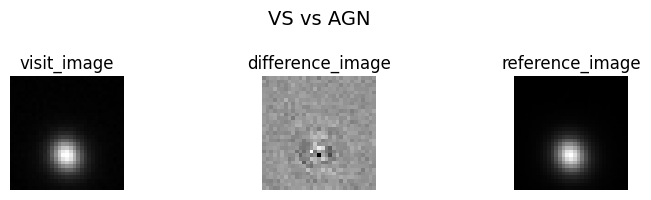

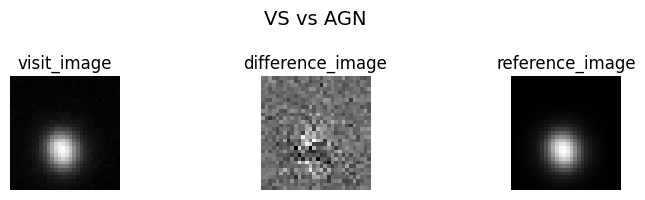

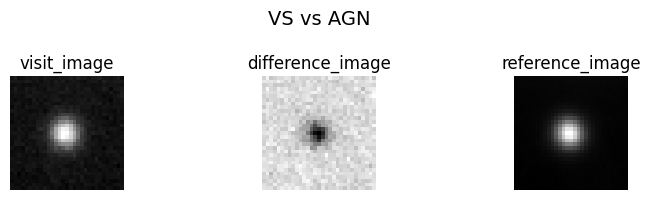

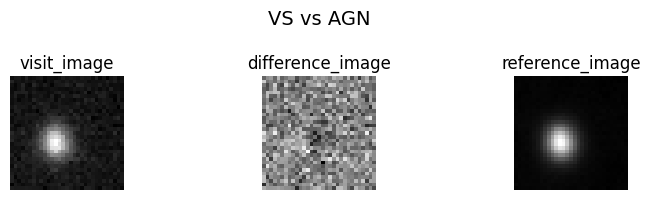

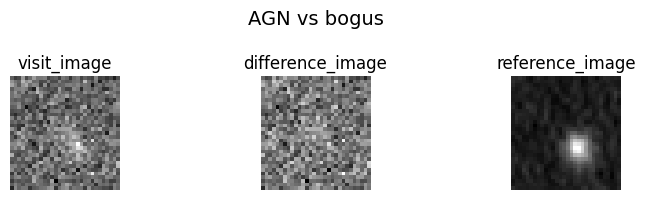

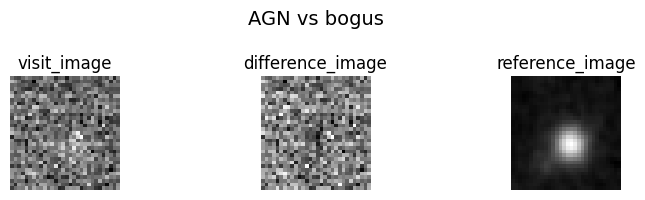

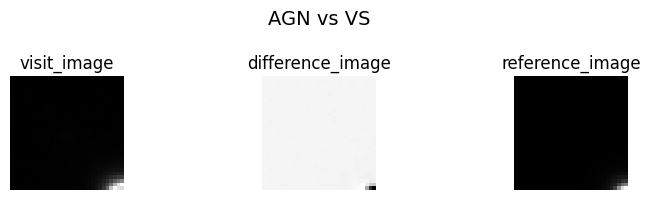

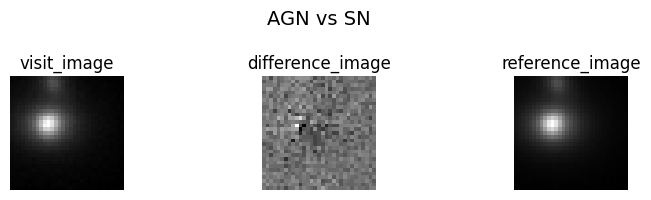

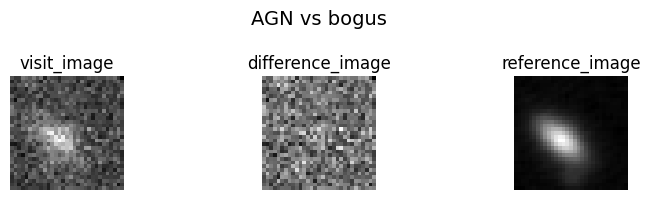

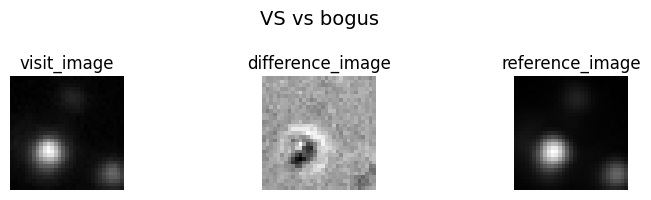

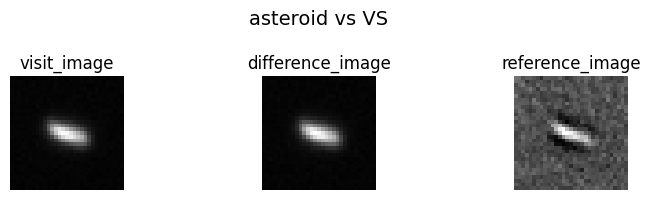

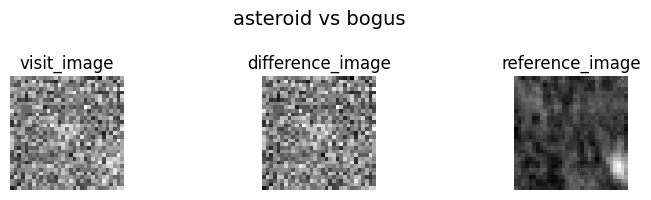

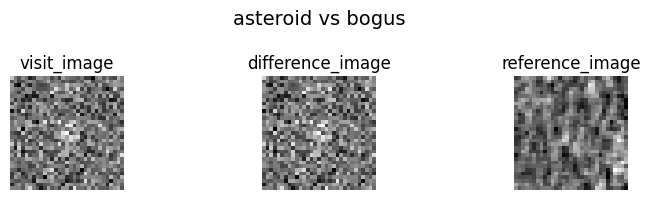

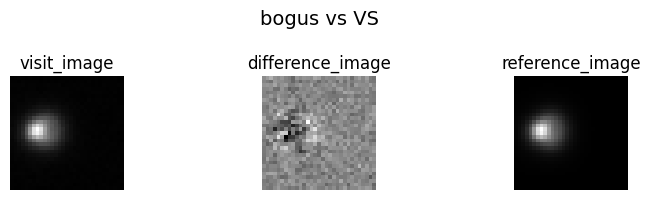

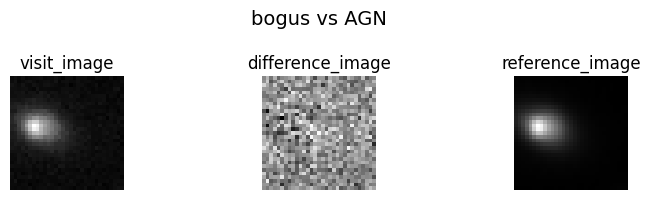

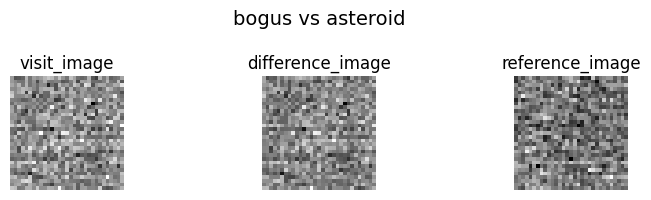

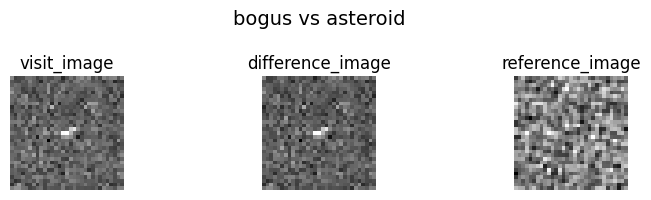

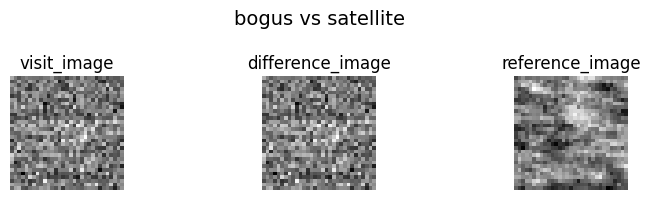

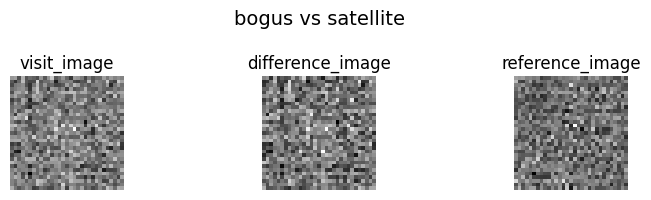

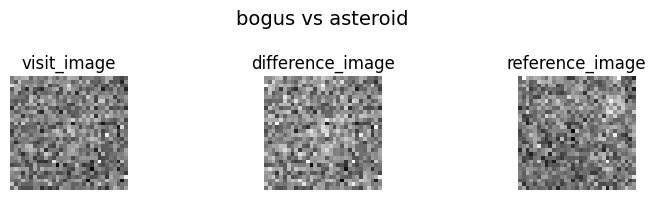

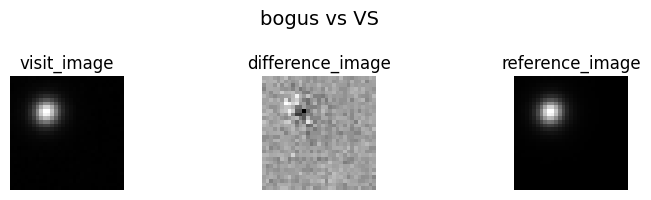

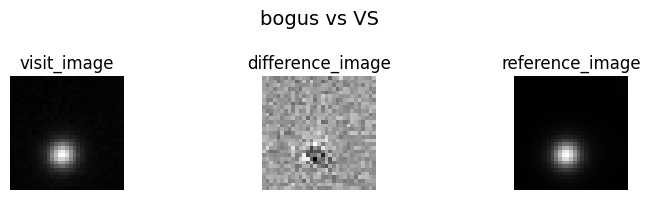

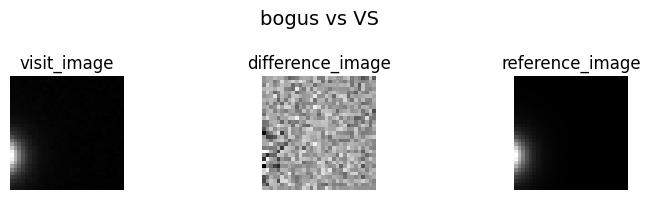

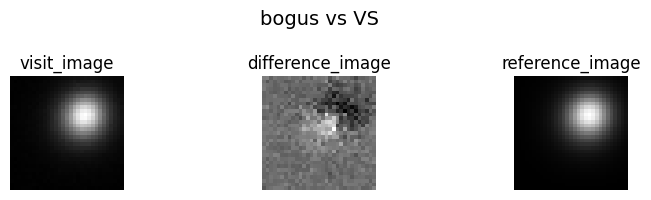

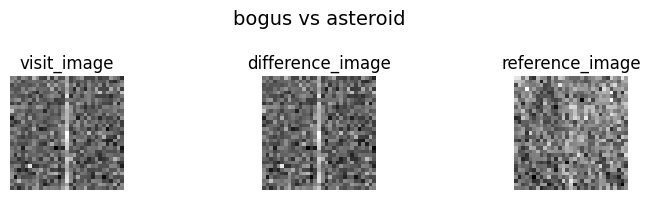

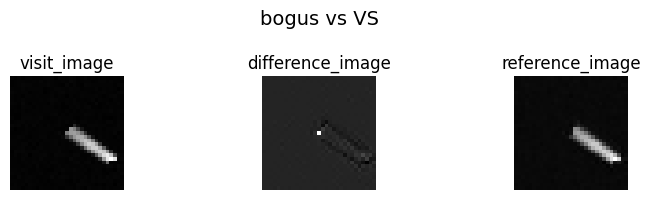

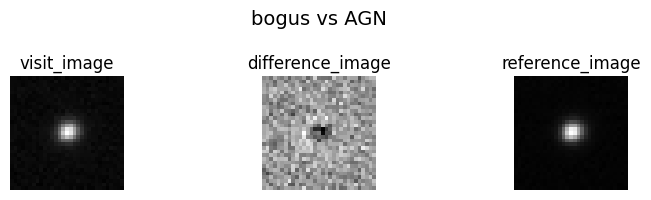

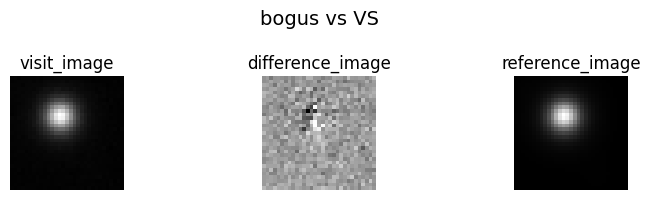

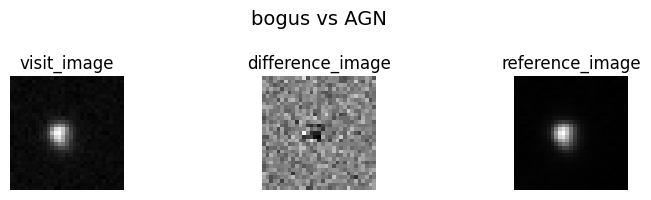

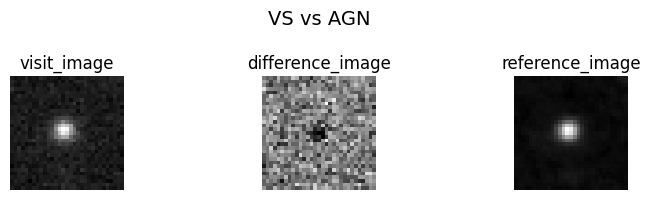

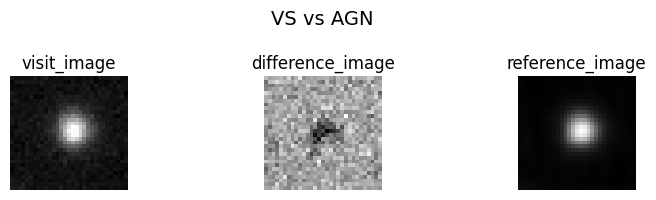

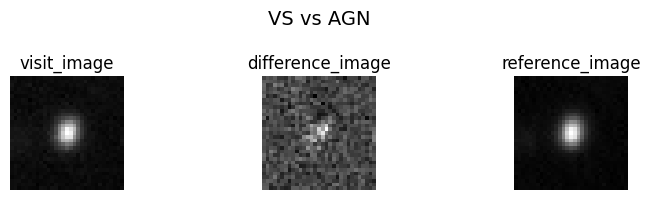

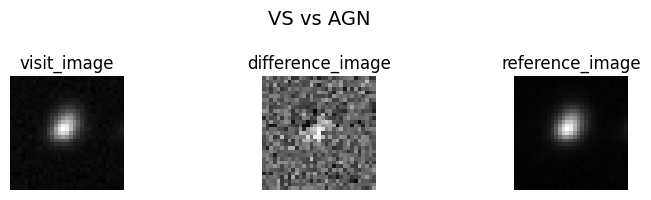

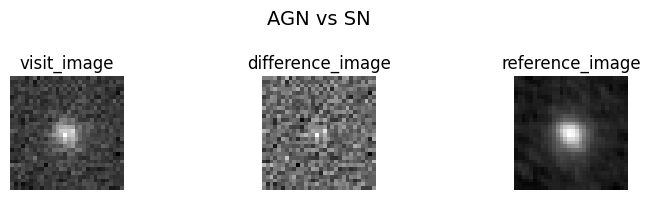

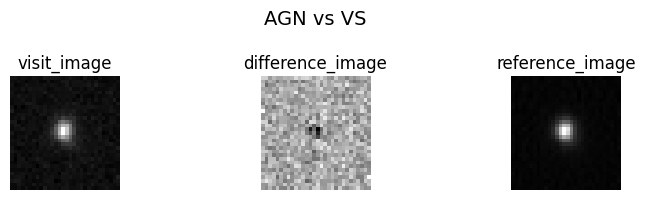

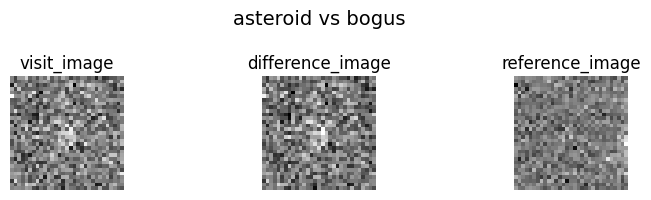

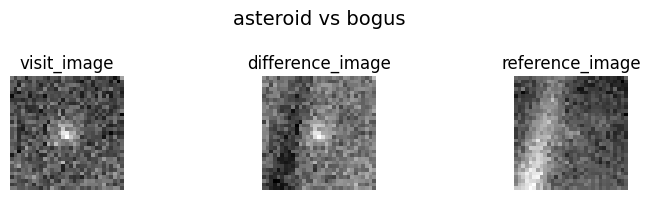

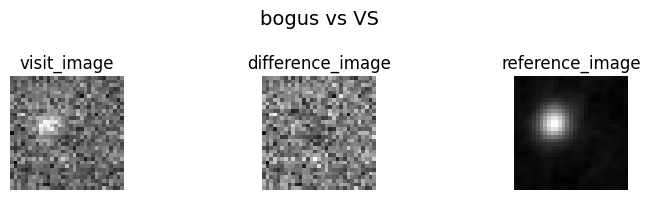

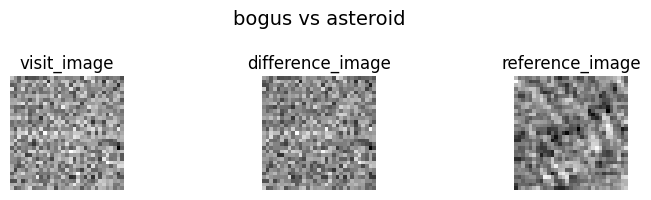

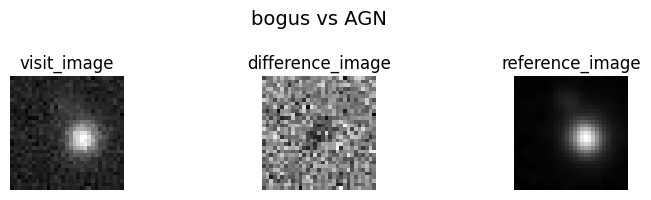

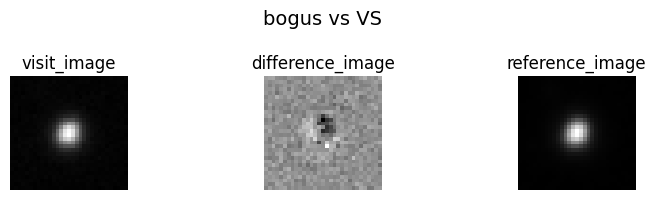

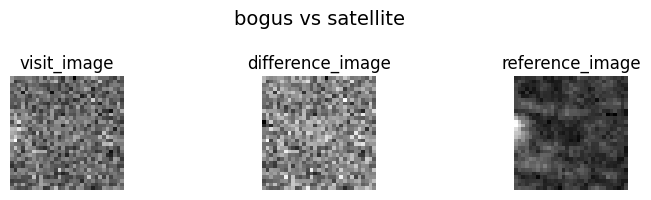

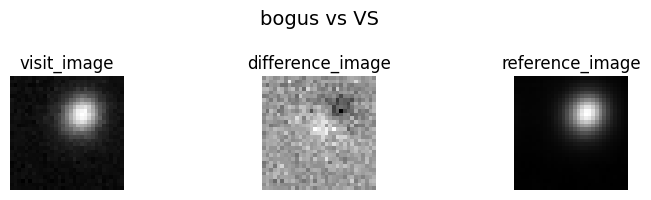

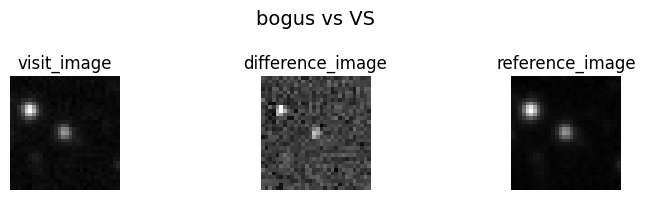

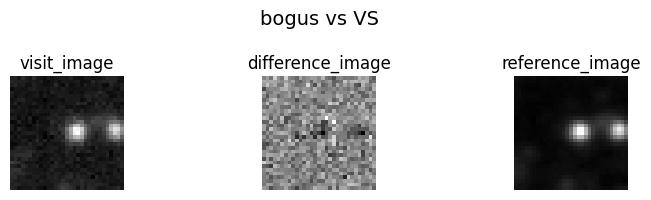

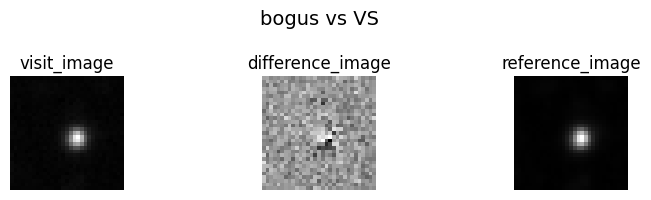

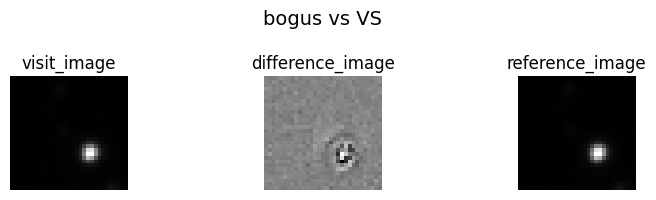

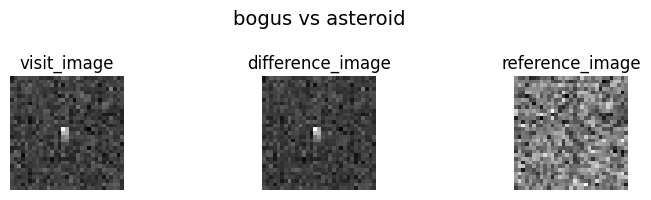

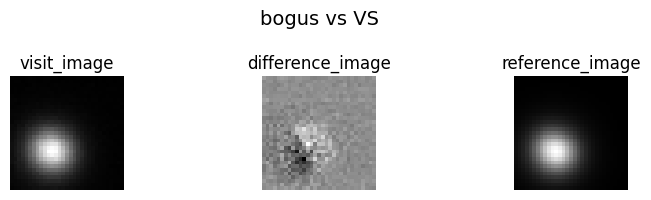

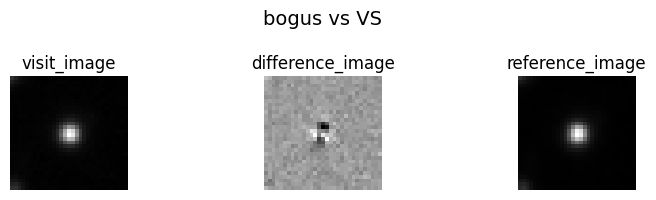

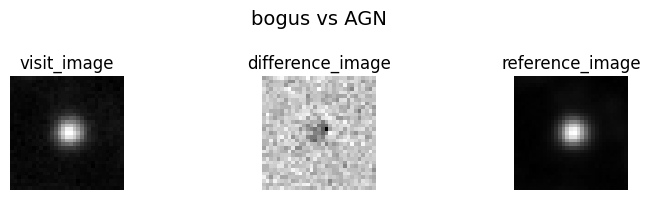

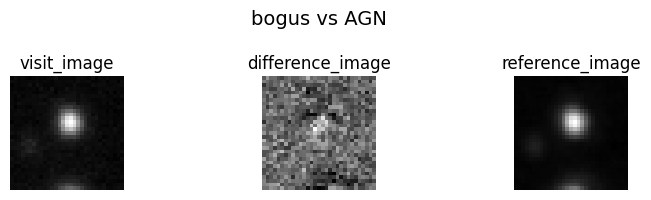

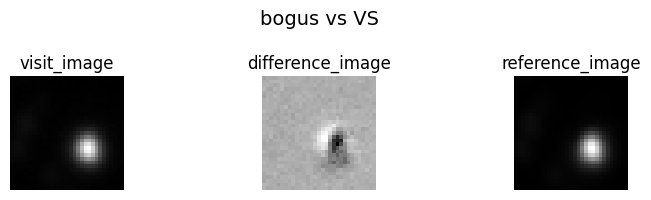

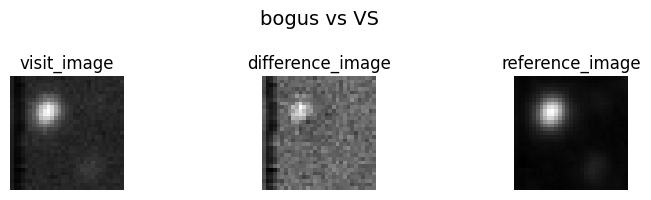

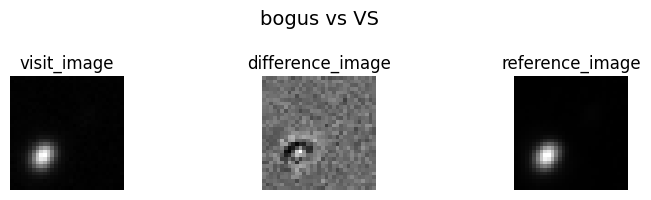

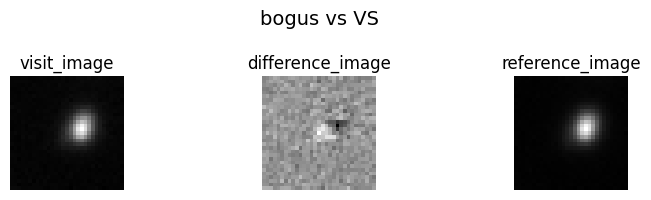

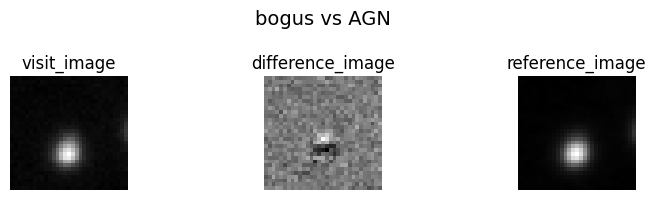

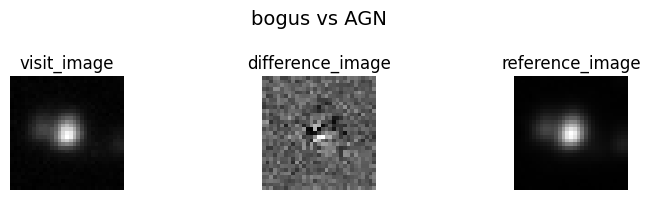

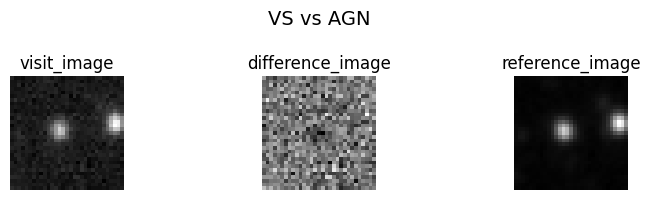

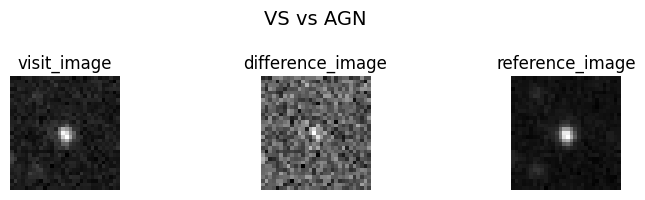

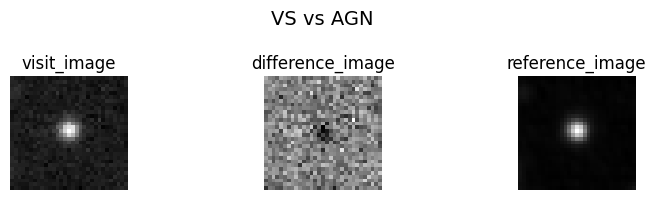

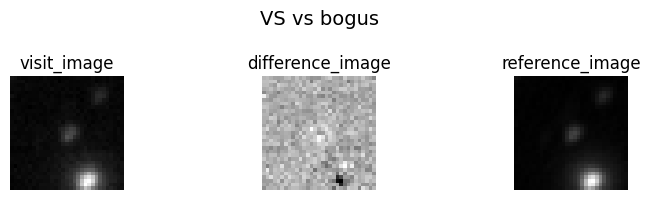

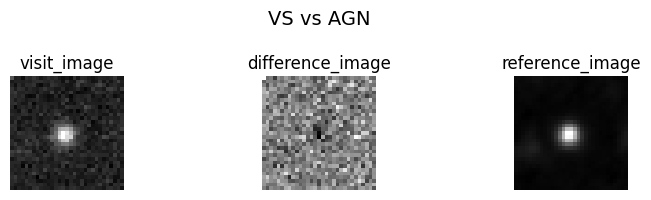

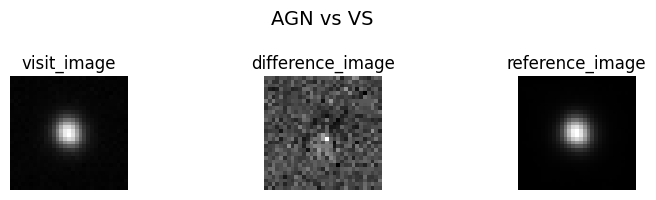

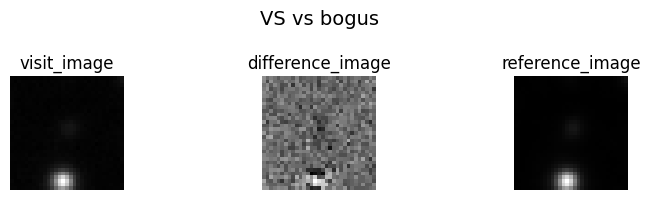

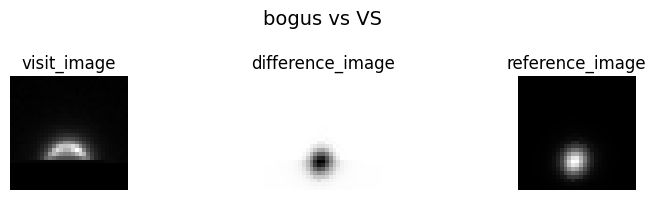

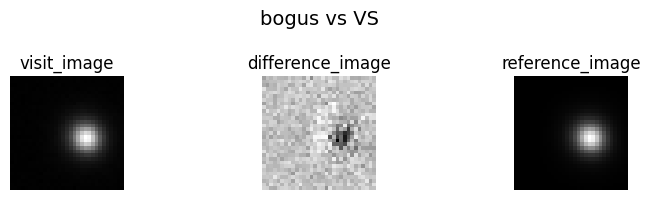

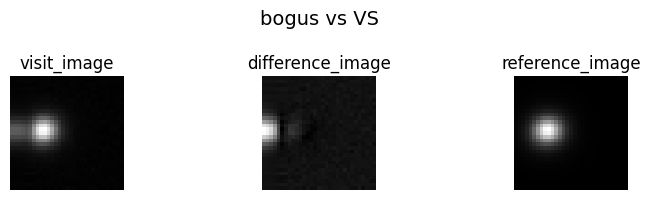

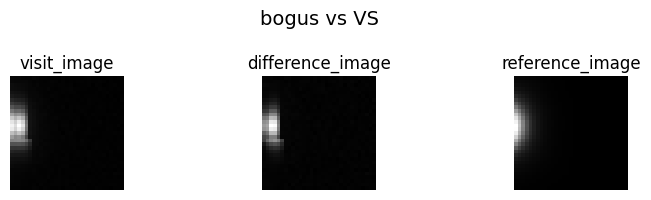

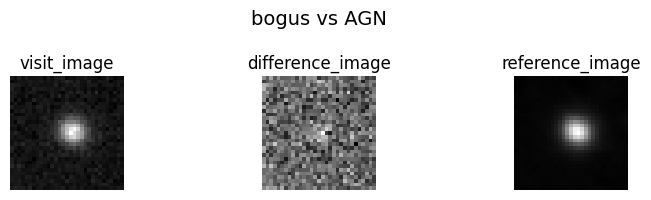

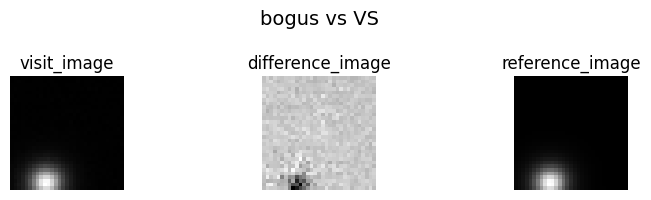

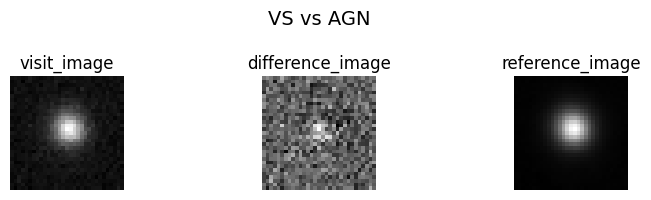

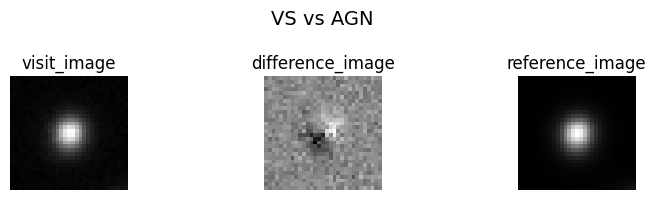

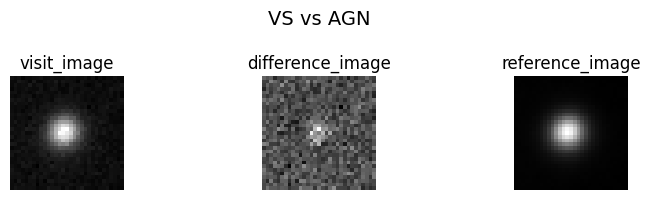

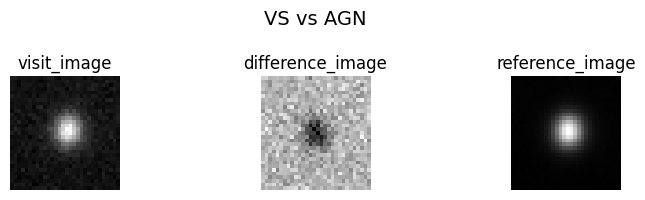

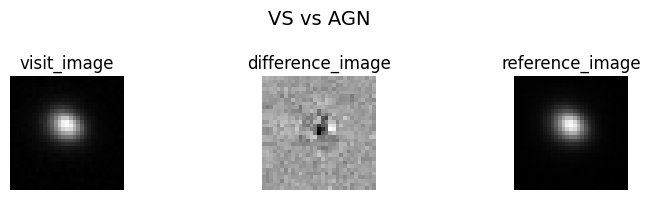

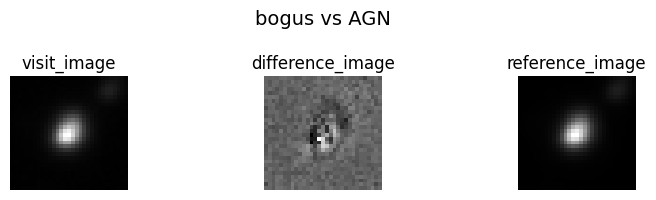

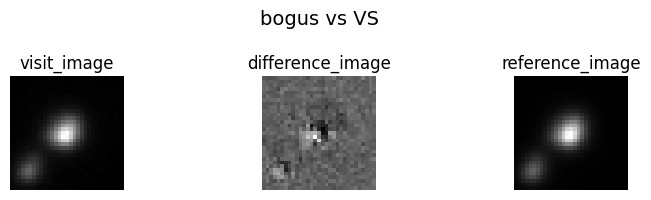

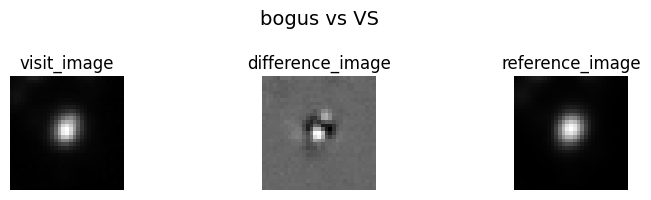

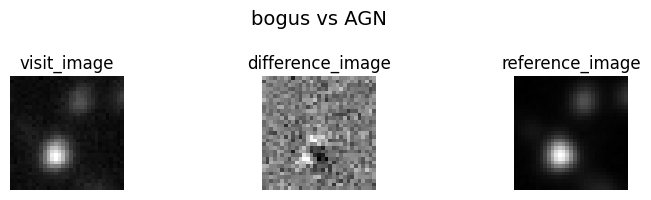

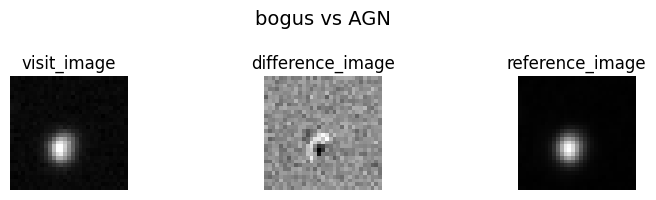

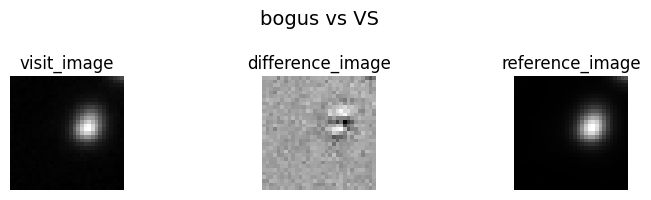

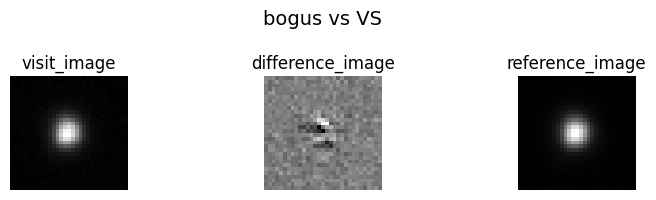

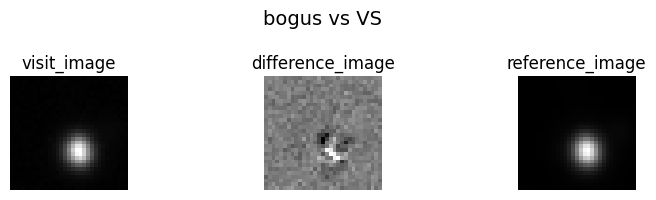

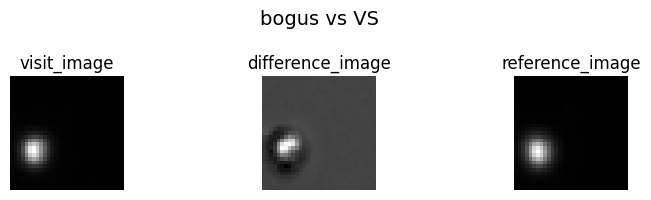

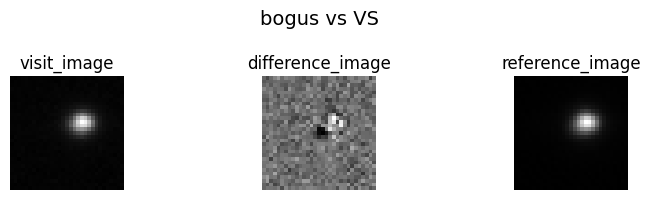

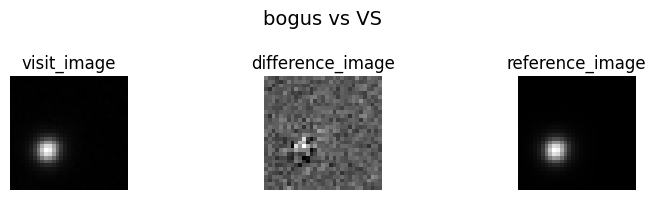

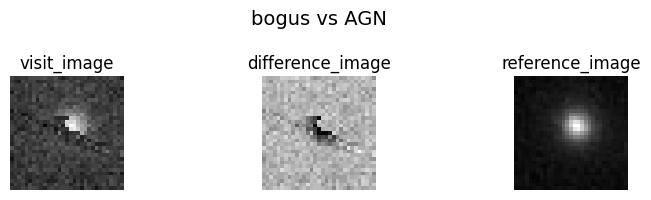

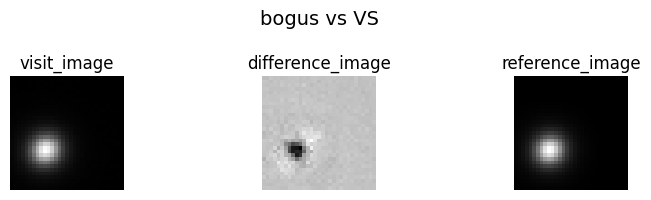

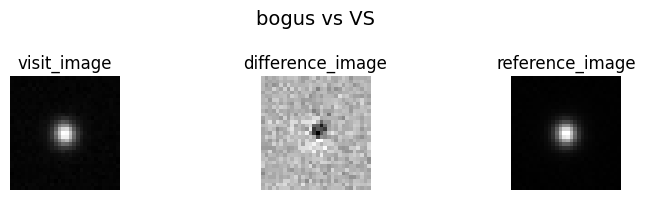

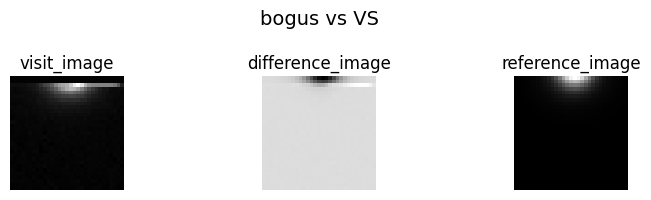

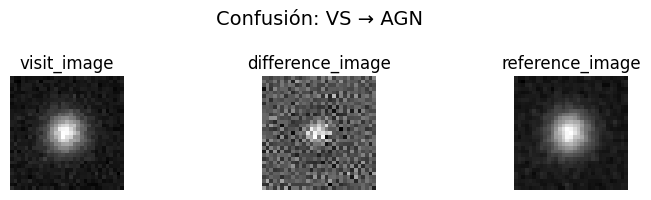

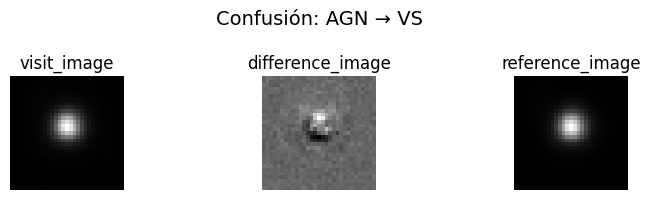

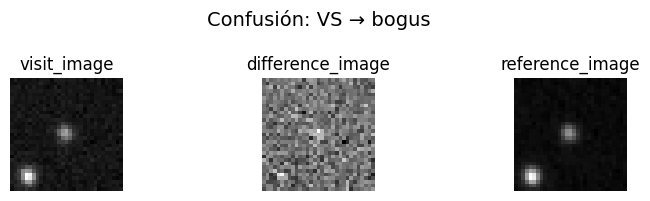

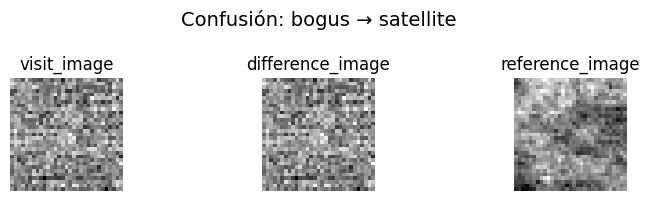

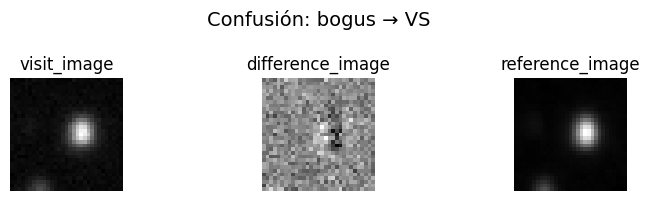

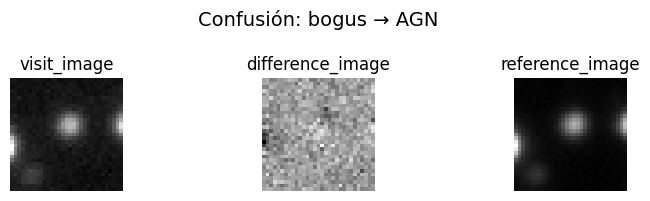

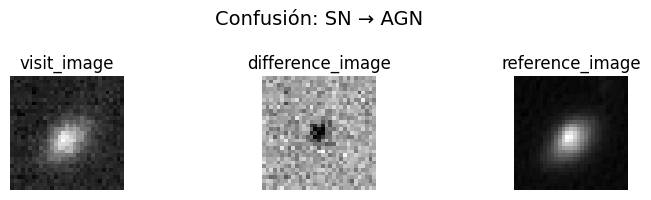

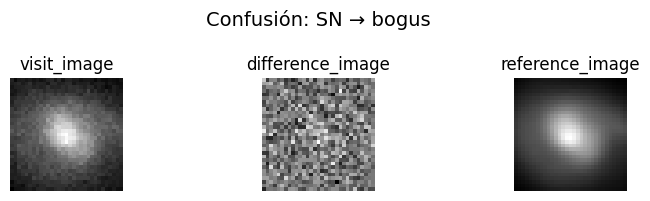

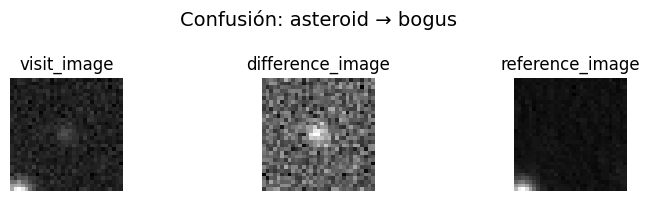

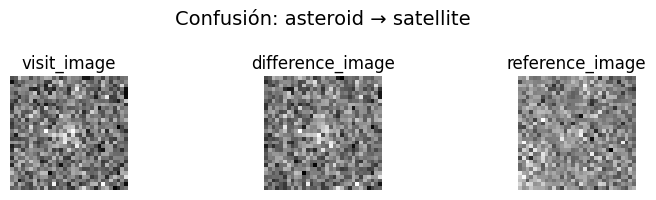

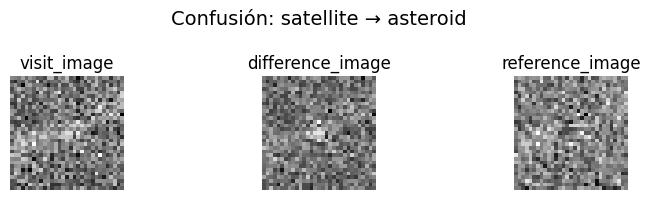

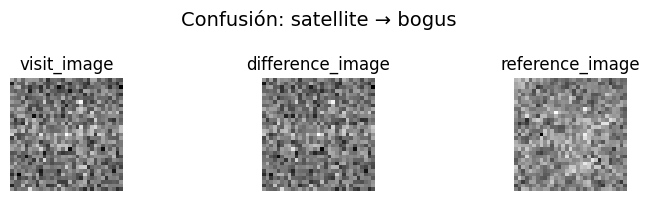

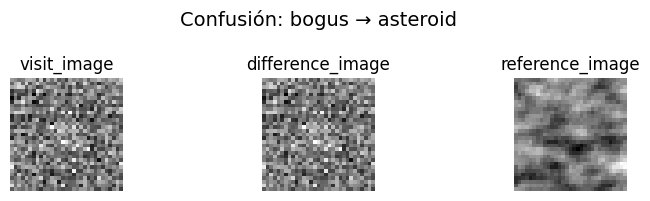

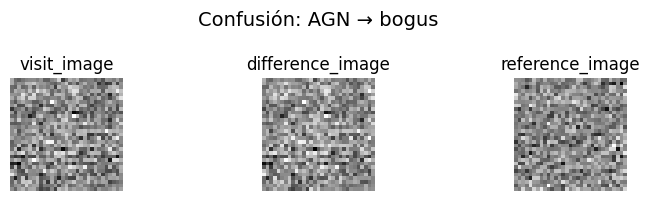

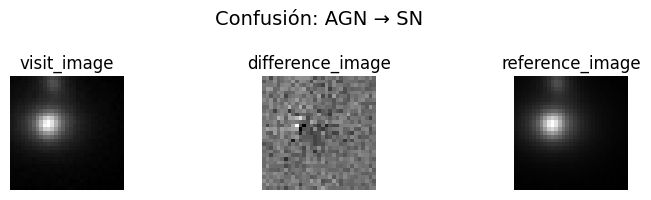

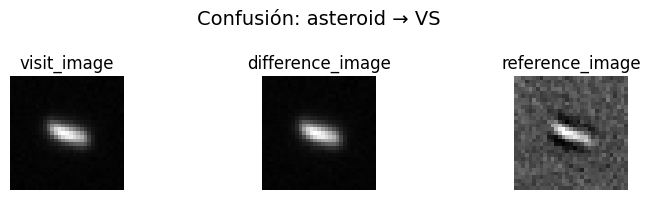

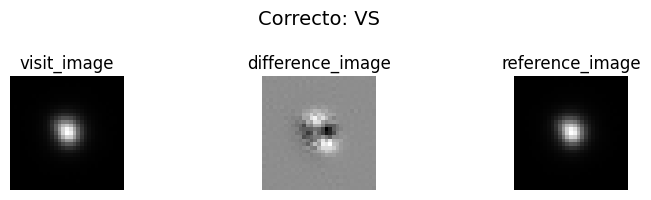

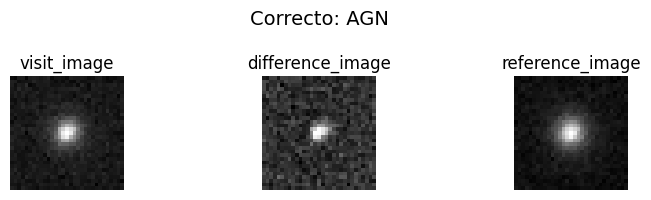

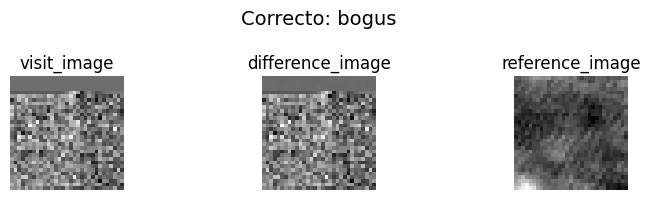

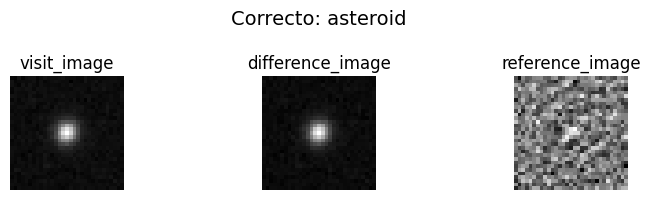

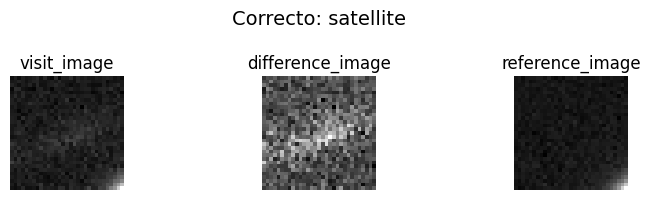

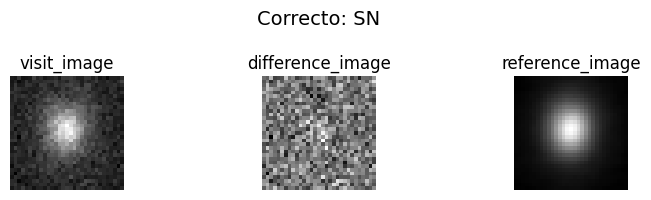

In [13]:
import cv2
def flip_negative_flux(padded_stamps, flux):
    """
    Flips the stamps with negative flux values to positive.
    """
    #solo la posicion 1: 'difference'
    negative_flux_mask = flux < 0
    if np.any(negative_flux_mask):
        #logging.info(f"Flipping {np.sum(negative_flux_mask)} stamps with negative flux values to positive.")
        padded_stamps[negative_flux_mask, :, :, 1] *= -1
    else:
        pass
    return padded_stamps

def process_stamp(data,args):
    stamp_cols = args['stamps_cols']
    stamps = data[stamp_cols].values
    max_h, max_w = get_max_hw(stamps)
    padded_stamps, padding_masks = prepare_model_input(stamps, max_h, max_w)  
    padded_stamps = flip_negative_flux(padded_stamps,data['psfFlux'].values)
    padded_stamps = normalize_stamps(padded_stamps, padding_masks)
    return padded_stamps

def process_metadata(
        data, 
        args, 
        dict_info_model, 
        norm_type='z-score', 
        path_norm_dir='./normalization_params', 
        is_test_only=False
        ):
    
    
    columns_to_rm = args['stamps_cols'] + [args['candid_col']] + ["target_name"] # nuevo
    metadata = data.drop(columns=columns_to_rm, axis=1)
    metadata = metadata.set_index(args['id_col'])

    coord_df = process_coordinates(
        oids=metadata.index,
        ra=metadata[args['ra_col']].values,
        dec=metadata[args['dec_col']].values,
        coord_type=args['coord_type'],
    )
    #por ahora estamos botando las coordenadas
    #metadata = pd.concat([metadata, coord_df], axis=1)
    metadata = metadata.drop(columns=[args['ra_col'], args['dec_col']])
    metadata = metadata.fillna(-999)

    ordered_cols = dict_info_model['order_features']
    metadata = metadata[ordered_cols]

    metadata = apply_normalization(
        metadata,
        norm_type=norm_type,
        dict_info_model=dict_info_model,
        path_norm_dir=path_norm_dir,
        is_test_only=is_test_only
    )
    return metadata


def perform_inference(data_path, model_path,zscore_path,path_partition,args,dict_info_model):

    #tengo que leer la data
    #tengo que leer el zscore_path
    #tengo que transformar la data
    #tengo que cargar el modelo
    #dejar la configuracion harcodeada
    #tengo que hacer la prediccion
    #tengo que guardar el resultado
    partition = pd.read_parquet(path_partition)
    oids_train = partition[partition['partition'] == 'training_0'][args['id_col']].tolist()
    oids_test = partition[partition['partition'] == 'test'][args['id_col']].tolist()
    data = []
    path_chunks = glob.glob(f"{data_path}/stamps/*.pkl")
    for path_chunk in path_chunks:
        data.append(pd.read_pickle(path_chunk))
    data = pd.concat(data)

    data_train = data[data[args['id_col']].isin(oids_train)]
    data_test = data[data[args['id_col']].isin(oids_test)]
    y_train = data_train['class'].values
    y_test = data_test['class'].values
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.fit_transform(y_test)
    #separar en test, obtener labels
    #print(data.columns)
    stamps = process_stamp(data_test,args)
    #stamps = add_center_mask(stamps, center_size=8)


    md_train = process_metadata(
        data_train, args, dict_info_model,
        norm_type=args['norm_type'], path_norm_dir=zscore_path, 
        is_test_only=False
    )
    md_test = process_metadata(
        data_test, args, dict_info_model,
        norm_type=args['norm_type'], path_norm_dir=zscore_path, 
        is_test_only=True
    )
    #print(md_train.head())

    clf = RandomForestClassifier()
    clf.fit(md_train,y_train)
    preds_test = clf.predict(md_test)

    #print(md_train.isna().sum())
    #print(md_test.isna().sum())

    dataset = tf.data.Dataset.from_tensors(((stamps, md_test),y_test))
    dataset = dataset.unbatch().batch(32).prefetch(5)

    stamp_classifier = tf.keras.models.load_model(
            model_path, custom_objects={"DynamicStampModel": DynamicStampModel})
    #display(stamp_classifier.summary())

    #print(y_test)

    for numero in range(6,20):
        #continue
        results = make_gradcam_per_rotation(
            stamp_classifier,
            stamps[numero][tf.newaxis, ...],
            md_test,
            target_layer_name="conv_3",
            include_flips=False,   # solo rotaciones, sin flips
            class_index=y_test[numero],
            training=False
        )
    
        
    
        def overlay(img_b1, heatmap, view_idx, channel, alpha=0.45):
            """
            Superpone heatmap sobre un solo canal de la imagen transformada.
            
            img_b1: (H,W,C) imagen original (ej: 6 canales)
            heatmap: (h,w) float [0..1]
            view_idx: 0..7 (rotaciones/flip)
            channel: canal a visualizar (int)
            """
            x = np.array(img_b1)  # (H,W,C)
        
            # --- aplicar misma transformación ---
            if view_idx == 0:
                x = np.rot90(x, k=4)
            if view_idx == 1:
                x = np.rot90(x, k=1)
            elif view_idx == 2:
                x = np.rot90(x, k=2)
            elif view_idx == 3:
                x = np.rot90(x, k=3)
            elif view_idx == 4:
                x = np.flipud(x)
            elif view_idx == 5:
                x = np.flipud(np.rot90(x, k=1))
            elif view_idx == 6:
                x = np.flipud(np.rot90(x, k=2))
            elif view_idx == 7:
                x = np.flipud(np.rot90(x, k=3))
        
            # --- elegir el canal ---
            vis = x[..., channel]  # (H,W
            #print(vis)
        
            # normalizar a uint8
            if vis.dtype != np.uint8:
                vmin, vmax = vis.min(), vis.max()
                vis = (255.0 * (vis - vmin) / (vmax - vmin + 1e-8)).astype(np.uint8)
        
            # expandir a 3 canales para el overlay
            vis = np.stack([vis]*3, axis=-1)  # (H,W,3)
        
            H, W = vis.shape[:2]
        
            # --- redimensionar heatmap ---
            #plt.imshow(heatmap)
            #plt.title("og")
            #plt.show()
            hm = cv2.resize(heatmap.astype(np.float32), (W, H), interpolation=cv2.INTER_LINEAR)
            hm_color = cv2.applyColorMap((hm * 255).astype(np.uint8), cv2.COLORMAP_JET)
            hm_color = cv2.cvtColor(hm_color, cv2.COLOR_BGR2RGB)
            #print(hm_color.shape)
        
            # --- mezclar ---
            overlayed = cv2.addWeighted(vis, 1.0, hm_color, alpha, 0)
            return overlayed
    
    
        # --- Plot: una fila por canal ---
        num_channels = 3          # canales que quieres visualizar (ej: 0,1,2)
        num_views = len(results)  # número de vistas (rotaciones/flip)
        
        fig, axes = plt.subplots(num_channels, num_views+1, figsize=(4*(num_views+1), 4*num_channels))
        
        for ch in range(num_channels):
            # columna 0: imagen original de ese canal
            vis = stamps[numero,:,:,ch]
            vmin, vmax = vis.min(), vis.max()
            vis_norm = (255.0 * (vis - vmin) / (vmax - vmin + 1e-8)).astype(np.uint8)
            axes[ch,0].imshow(vis_norm, cmap="gray")
            axes[ch,0].set_title(f"Canal {ch} - Input")
            axes[ch,0].axis("off")
        
            # resto: overlays
            for i, (name, out) in enumerate(results.items(), start=0):
                #print(i,name,out)
                hm = out["heatmap"]
                overlayed = overlay(stamps[numero,:,:,:3], hm, i, channel=ch)
                axes[ch,i+1].imshow(overlayed)
                axes[ch,i+1].set_title(f"Canal {ch} - {name}\nclass={out['class']}")
                axes[ch,i+1].axis("off")
        
        plt.tight_layout()
        plt.show()


    
    
    _,_,_, y_true_all, y_pred_all = eval_step(stamp_classifier, dataset)

    labels_map = dict_info_model["dict_mapping_classes"]
    target_names = [labels_map[i] for i in sorted(labels_map)]

    # Report
    report = classification_report(y_true_all, y_pred_all, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df.round(2))

    report = classification_report(y_true_all, preds_test, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df)

    # Confusion Matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix - {'test'}")
    plt.show()

    cm = confusion_matrix(y_true_all, y_pred_all,normalize="true")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix normalized - {'test'}")
    plt.show()

    cm = confusion_matrix(y_true_all, preds_test)
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix - {'test RF'}")
    plt.show()

    cm = confusion_matrix(y_true_all, preds_test,normalize ="true")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix normalized - {'test RF'}")
    plt.show()

    #md_train.hist(figsize=(10, 8))
    #plt.show()
    #display(md_train.describe())

    #get mistakes
    #print(y_true_all)
    #print(target_names)
    #print(y_pred_all)
    
    
    canales = ['visit_image','difference_image','reference_image']
    mismatch_indices = np.where(y_true_all != y_pred_all)[0]
    for indice in mismatch_indices:
        clase_real = target_names[y_true_all[indice]]
        clase_pred = target_names[y_pred_all[indice]]
        #stamp = stamps[indice][:,:,:3]
        fig, axes = plt.subplots(1, 3, figsize=(8, 2))  # 1 fila, 3 columnas

        # Mostrar cada canal en un subplot
        for i in range(3):
            axes[i].imshow(data_test[canales[i]].values[indice], cmap='gray')
            axes[i].axis('off')  # Ocultar ejes
            axes[i].set_title(canales[i])
        
        # Título general
        fig.suptitle(f"{clase_real} vs {clase_pred}", fontsize=14)
        
        plt.tight_layout()
        plt.show()
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    from collections import defaultdict
    
    canales = ['visit_image','difference_image','reference_image']
    N = 1  # Número de ejemplos por tipo de confusión
    
    # Diccionarios para guardar índices
    confusiones = defaultdict(list)
    correctas = defaultdict(list)
    
    # Recorrer todos los ejemplos
    for idx, (y_t, y_p) in enumerate(zip(y_true_all, y_pred_all)):
        if y_t == y_p:
            if len(correctas[y_t]) < N:
                correctas[y_t].append(idx)
        else:
            if len(confusiones[(y_t, y_p)]) < N:
                confusiones[(y_t, y_p)].append(idx)
    
    # Mostrar confusiones
    for (real, pred), indices in confusiones.items():
        for indice in indices:
            clase_real = target_names[real]
            clase_pred = target_names[pred]
    
            fig, axes = plt.subplots(1, 3, figsize=(8, 2))
            for i in range(3):
                axes[i].imshow(data_test[canales[i]].values[indice], cmap='gray')
                axes[i].axis('off')
                axes[i].set_title(canales[i])
            fig.suptitle(f"Confusión: {clase_real} → {clase_pred}", fontsize=14)
            plt.tight_layout()
            plt.show()
    
    # Mostrar clasificaciones correctas
    for clase, indices in correctas.items():
        for indice in indices:
            clase_nombre = target_names[clase]
            fig, axes = plt.subplots(1, 3, figsize=(8, 2))
            for i in range(3):
                axes[i].imshow(data_test[canales[i]].values[indice], cmap='gray')
                axes[i].axis('off')
                axes[i].set_title(canales[i])
            fig.suptitle(f"Correcto: {clase_nombre}", fontsize=14)
            plt.tight_layout()
            plt.show()

    return 

if __name__ == "__main__":
    args = {'stamps_cols': ['visit_image','difference_image','reference_image'], 'candid_col': 'diaSourceId',
             'id_col': 'diaObjectId', 'ra_col': 'ra', 
             'dec_col': 'dec', 'coord_type': 'spherical', 
             'norm_type': 'z-score'}
    
    dict_info_model = {'order_features': ["airmass","magLim","psfFlux","psfFluxErr",
                                          'scienceFlux','scienceFluxErr','seeing','snr'],
                       "dict_mapping_classes":{0: 'AGN', 1: 'SN', 2: 'VS', 3: 'asteroid', 4: 'bogus', 5: 'satellite'}}

    perform_inference(data_path = './../../../data_acquisition/rubin/data/processed/ts_stamps_v0.0.4_dp1/',
                      model_path = './results/ml-runs/185220183588321487/f2952a3ae1e24b07ac138edf6ef33c5c/artifacts/model.keras',
                      zscore_path= './results/ml-runs/185220183588321487/f2952a3ae1e24b07ac138edf6ef33c5c/artifacts/',
                      path_partition='./../../../data_acquisition/rubin/data/processed/partitions/ts_stamps_v0.0.4_dp1/partitions.parquet',
                      args=args, dict_info_model=dict_info_model) 